# 

In [1]:
# === Environment Setup (France Holiday Compatible, Kaggle Safe) ===
TARGET = "/kaggle/working/libs"

!pip install -q --no-cache-dir --target "$TARGET" \
    "numpy==1.26.4" \
    "scipy==1.11.4" \
    "pandas==2.2.2" \
    "scikit-learn==1.6.1" \
    "matplotlib==3.8.4" \
    "seaborn==0.13.2" \
    "meteostat==1.6.8" \
    "holidays==0.57" \
    "jours-feries-france==0.6.0" \
    "darts==0.38.0" \
    "qolmat==0.1.10"

import sys
if TARGET not in sys.path:
    sys.path.insert(0, TARGET)

# --- Imports ---
import numpy, scipy, pandas, sklearn
from sklearn.impute import SimpleImputer
from meteostat import Point, Daily
import holidays
from jours_feries_france import JoursFeries
from qolmat.imputations import imputers
print("✅ Core imports OK")

# --- Optional helper: pseudo French school holidays generator ---
import pandas as pd
from datetime import datetime

def add_school_holiday_feature(df, date_col="id"):
    """
    Approximate French school holidays based on common calendar pattern:
    - Winter (mid-Feb to early Mar)
    - Spring (mid-Apr)
    - Summer (Jul–Aug)
    - Autumn (late Oct–early Nov)
    - Christmas (late Dec–early Jan)
    """
    d = df.copy()
    d["month"] = d[date_col].dt.month
    d["day"] = d[date_col].dt.day

    def is_school_holiday(row):
        m, day = row["month"], row["day"]
        if m in [7, 8]:  # Summer
            return True
        if (m == 2 and day >= 10) or (m == 3 and day <= 5):  # Winter break
            return True
        if (m == 4 and day >= 10) or (m == 5 and day <= 5):  # Spring break
            return True
        if (m == 10 and day >= 25) or (m == 11 and day <= 5):  # Autumn break
            return True
        if (m == 12 and day >= 20) or (m == 1 and day <= 5):  # Christmas
            return True
        return False

    d["is_school_holiday"] = d.apply(is_school_holiday, axis=1)
    d.drop(columns=["month", "day"], inplace=True)
    return d

print("✅ Helper function for school holidays ready.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 31.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 238.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 66.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 206.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 149.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 254.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 285.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 156.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 90.8 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 111.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/2025airqualityparis/sample_submission.csv
/kaggle/input/2025airqualityparis/train.csv
/kaggle/input/2025airqualityparis/test.csv


In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

# Load and EDA

**Load and Examine the Data**
- Load Training Data: Load train.csv and inspect the first few rows.
- Understand the Structure: Check data types, summary statistics, and null values.
- Time Range Check: Confirm the date range in the dataset and compare it with the testing period.

**Analyze Missing Values**
- Identify Missing Patterns: Check for missing values per feature, including time-based patterns.
- Visualize Missing Data: Use a heatmap or line plot to show missing values over time for each feature.

**Distribution and Outliers**
- Plot Distributions: Plot histograms or boxplots for each pollutant to understand their distributions and detect outliers.
- Time Series Patterns: Plot time series for each pollutant (over days, weeks, months) to observe trends, seasonality, and anomalies.

**Correlation Analysis**
- Correlation Matrix: Compute and plot correlations between pollutants to identify relationships.
- Autocorrelation: Calculate autocorrelation for each pollutant to understand its temporal dependency.

**Trend and Seasonality Analysis**
- Seasonal Decomposition: Decompose the time series data to separate trend, seasonality, and residuals for each pollutant.
- Monthly/Weekly Patterns: Group data by month, week, and day to detect any seasonal patterns in pollutant levels.
- Hour of Day Patterns: Analyze if pollutant levels vary significantly across different hours of the day.

In [4]:
train_df = pd.read_csv('/kaggle/input/2025airqualityparis/train.csv')
test_df = pd.read_csv('/kaggle/input/2025airqualityparis/test.csv')

In [5]:
#preview
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
train_df.head()

Train Data Shape: (40991, 6)
Test Data Shape: (504, 1)


,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2020-01-01 00,42.9,0.718,15.7,73.1,64.4
1,2020-01-01 01,33.6,0.587,10.1,74.8,66.0
2,2020-01-01 02,29.3,NaN,5.1,51.0,44.9
3,2020-01-01 03,30.5,0.246,7.2,27.7,25.1
4,2020-01-01 04,29.3,0.204,8.3,15.3,13.6


In [6]:
# Convert 'id' column to datetime & set it as the index
train_df['id'] = pd.to_datetime(train_df['id'], format='%Y-%m-%d %H')
test_df['id'] = pd.to_datetime(test_df['id'], format='%Y-%m-%d %H')
train_df.set_index('id', inplace=True)
test_df.set_index('id', inplace=True)

# Summary
print("\nBasic Info:")
print(train_df.info())
print("\nSummary Statistics:")
print(train_df.describe())


Basic Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 40991 entries, 2020-01-01 00:00:00 to 2024-09-03 22:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   valeur_NO2   37694 non-null  float64
 1   valeur_CO    28462 non-null  float64
 2   valeur_O3    40298 non-null  float64
 3   valeur_PM10  33824 non-null  float64
 4   valeur_PM25  39200 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB
None

Summary Statistics:
         valeur_NO2     valeur_CO     valeur_O3   valeur_PM10   valeur_PM25
count  37694.000000  28462.000000  40298.000000  33824.000000  39200.000000
mean      21.831528      0.200710     50.574349     18.221523     11.051161
std       14.658381      0.103691     26.488626     11.282385      8.151742
min        1.100000      0.037000     -1.900000      0.500000      0.000000
25%       11.300000      0.145000     33.000000     10.700000      5.800000
50%       17.600000      0.1


Missing Values per Feature:
valeur_NO2      3297
valeur_CO      12529
valeur_O3        693
valeur_PM10     7167
valeur_PM25     1791
dtype: int64


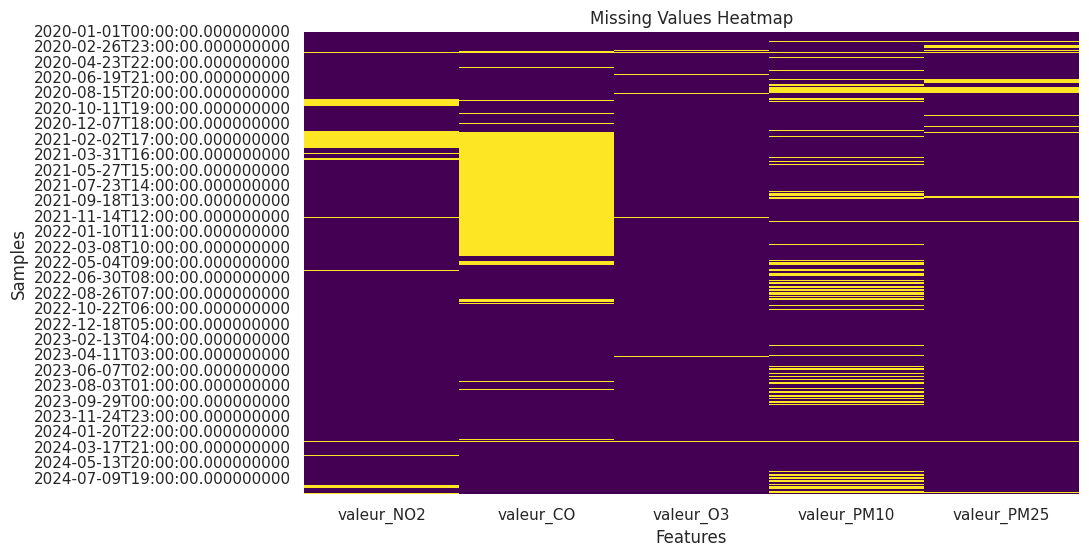

In [7]:
# Missing Value Analysis
missing_values = train_df.isnull().sum()
print("\nMissing Values per Feature:")
print(missing_values)

# Visualize Missing Data
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Samples")
plt.show()

According to the figure above, there's obvious gap in valeur_NO2, valeur_CO and valeur_PM10, especially valeur_CO. This characteristic suggests that for large gaps in missing values, imputation may not be proper, and removal might be a more appropriate handling method.

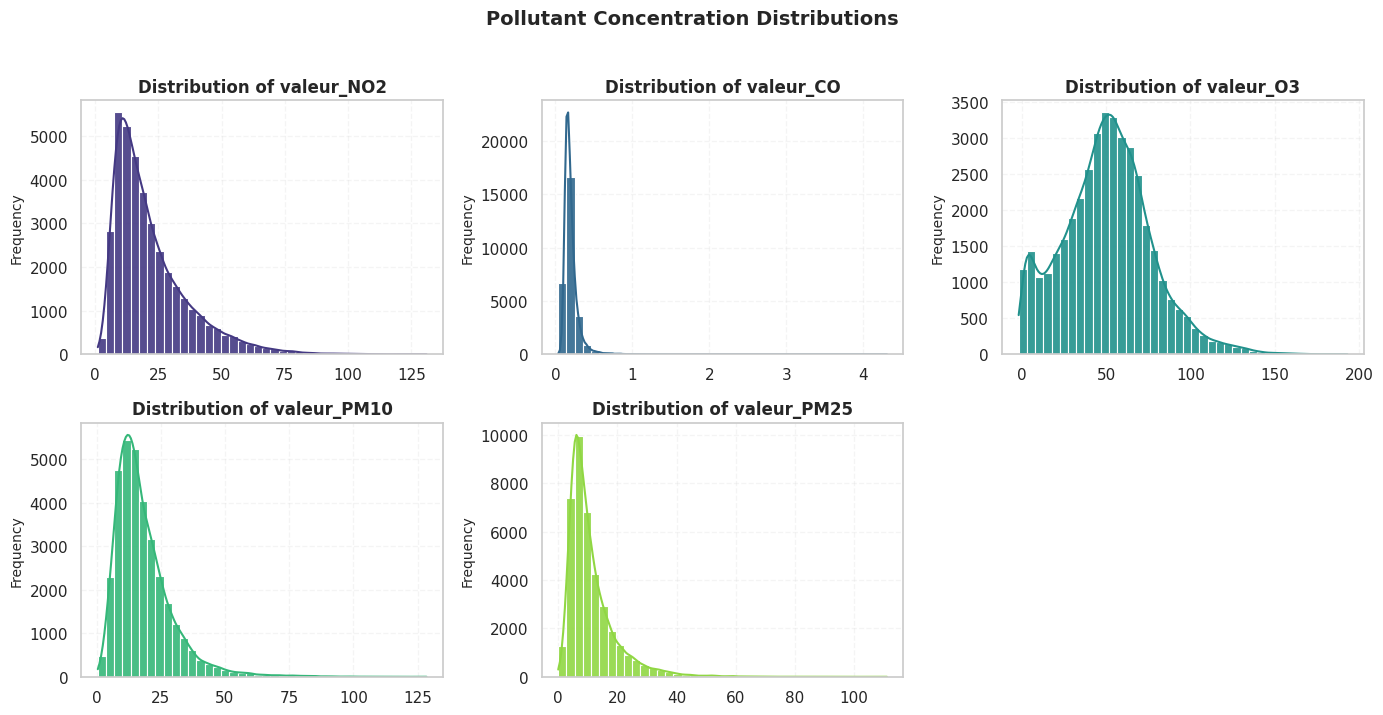

In [8]:
# Plot histograms for each pollutant
pollutants = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']

plt.figure(figsize=(14, 7))
for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    sns.histplot(
        train_df[pollutant].dropna(),
        kde=True,
        bins=40,
        color=sns.color_palette("viridis", 5)[i-1],
        edgecolor="white",
        linewidth=0.8,
        alpha=0.9
    )
    plt.title(f"Distribution of {pollutant}", fontsize=12, fontweight="bold")
    plt.xlabel("")
    plt.ylabel("Frequency", fontsize=10)
    plt.grid(alpha=0.2, linestyle="--")

plt.suptitle("Pollutant Concentration Distributions", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


Each distribution shows a right-skewed shape, indicating that lower values are more common, with a long tail extending towards higher values. This suggests that high concentrations are less frequent across these pollutants.

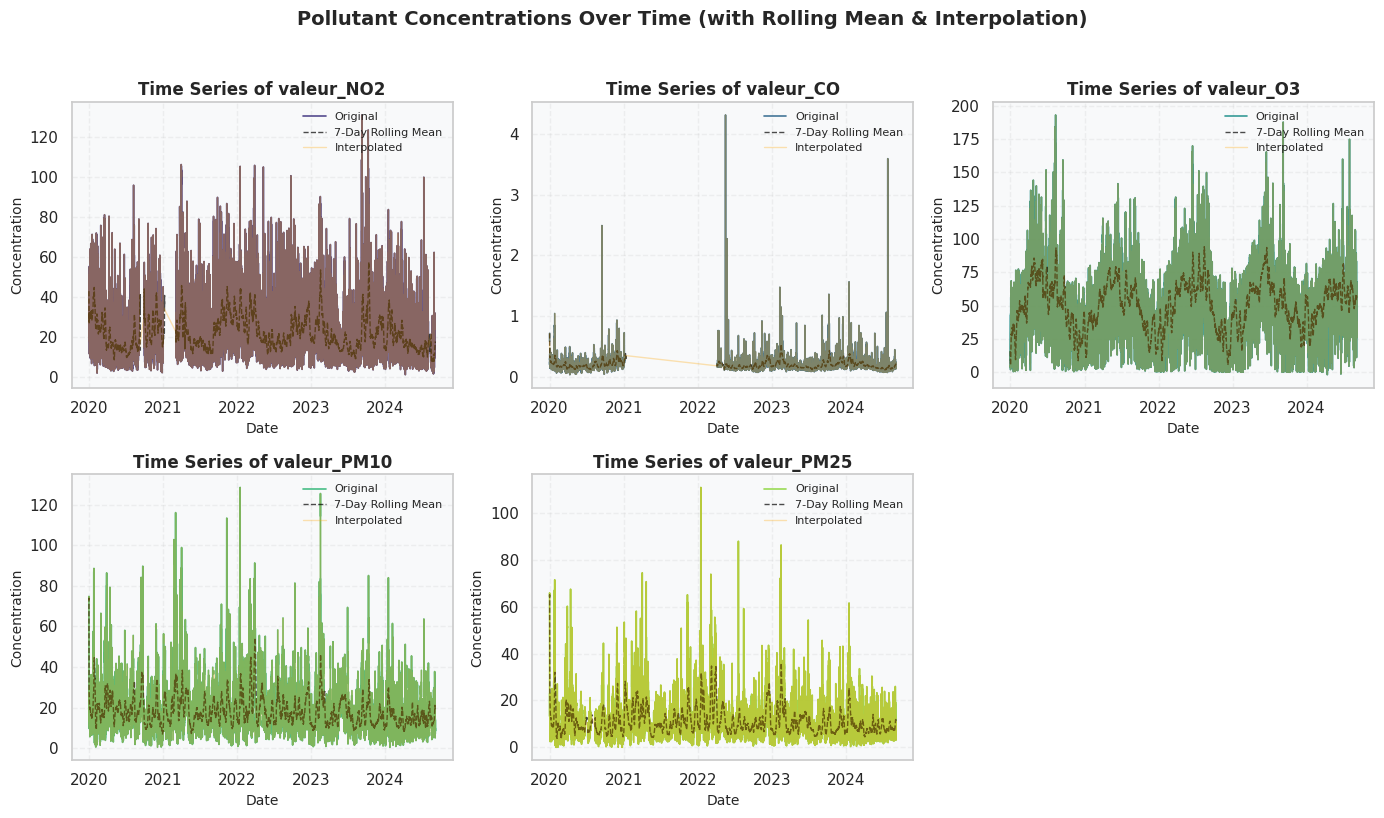

In [9]:
# Plot time series for each pollutant with enhanced style and rolling/interpolated lines
pollutants = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']

plt.figure(figsize=(14, 8))
palette = sns.color_palette("viridis", len(pollutants))

for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)

    # --- Original raw time series ---
    plt.plot(
        train_df.index,
        train_df[pollutant],
        color=palette[i-1],
        linewidth=1.2,
        alpha=0.9,
        label="Original"
    )

    # --- Rolling mean (7 days = 24h * 7) ---
    plt.plot(
        train_df[pollutant].rolling(window=24*7, min_periods=1).mean(),
        color="black",
        linewidth=1.0,
        linestyle="--",
        alpha=0.7,
        label="7-Day Rolling Mean"
    )

    # --- Interpolated series (highlight missing-value gaps) ---
    plt.plot(
        train_df[pollutant].interpolate(),
        color="orange",
        linewidth=1.0,
        alpha=0.3,
        label="Interpolated"
    )

    # --- Title and labels ---
    plt.title(f"Time Series of {pollutant}", fontsize=12, fontweight="bold", pad=5)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Concentration", fontsize=10)

    # --- Aesthetic adjustments ---
    plt.grid(alpha=0.25, linestyle="--")
    plt.gca().set_facecolor("#f8f9fa")  # light background
    plt.legend(loc="upper right", fontsize=8, frameon=False)

plt.suptitle("Pollutant Concentrations Over Time (with Rolling Mean & Interpolation)",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


There are obvious gaps in NO₂ and CO, which is consistent with the missing-value heatmap. In addition, O₃ shows a clear cyclical pattern likely driven by seasonal effects.
After adding the 7-day rolling mean and interpolation, the overall trends remain consistent — the smoothing mainly reduces short-term noise while preserving the underlying dynamics, confirming that the raw data already captured the main temporal patterns accurately.

In [10]:
# Compute correlation matrix
correlation_matrix = train_df.corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)


Correlation Matrix:
             valeur_NO2  valeur_CO  valeur_O3  valeur_PM10  valeur_PM25
valeur_NO2     1.000000   0.707436  -0.641281     0.509953     0.520438
valeur_CO      0.707436   1.000000  -0.482845     0.531823     0.627073
valeur_O3     -0.641281  -0.482845   1.000000    -0.208749    -0.296609
valeur_PM10    0.509953   0.531823  -0.208749     1.000000     0.887796
valeur_PM25    0.520438   0.627073  -0.296609     0.887796     1.000000


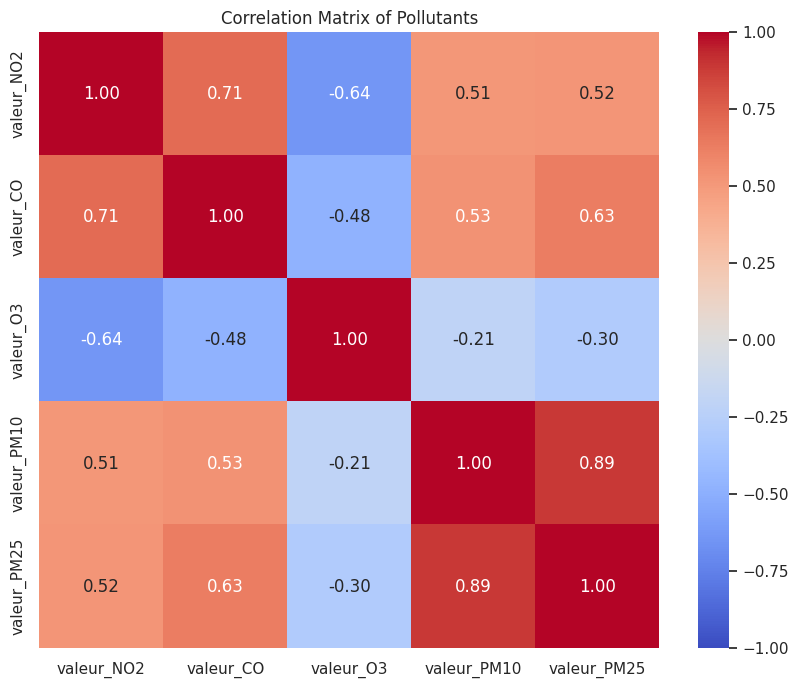

In [11]:
# Visualize Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title("Correlation Matrix of Pollutants")
plt.show()

valeur_NO2 and valeur_CO, valeur_PM25 and valeur_PM10, valeur_PM25 and valeur_CO have relatively high positive correlation. valeur_O3 and valeur_NO2, valeur_O3 and valeur_CO, valeur_PM10 and valeur_O3, valeur_PM25 and valeur_O3 are negatively correlated.

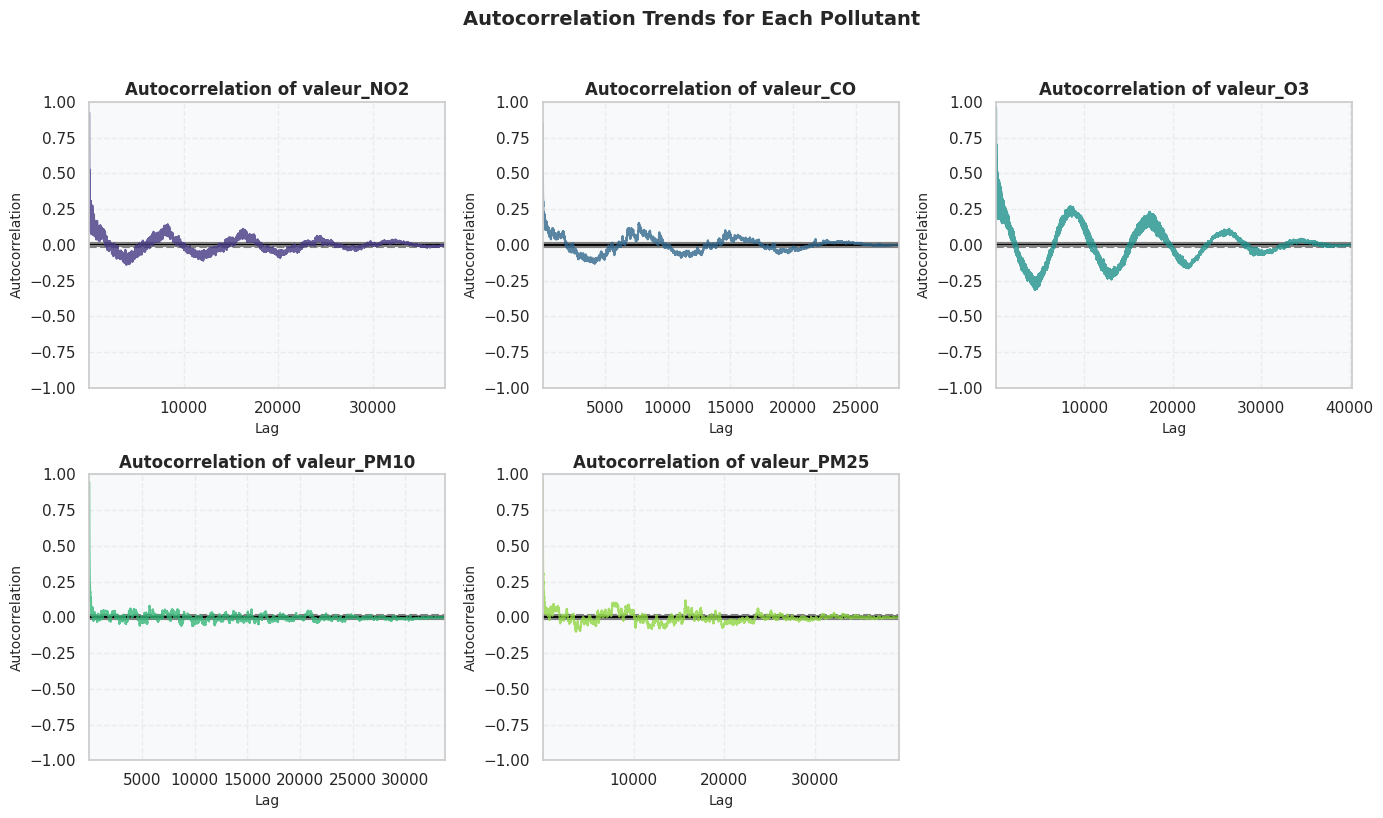

In [12]:
from pandas.plotting import autocorrelation_plot

# Plot autocorrelation (ACF) trends for each pollutant
plt.figure(figsize=(14, 8))
palette = sns.color_palette("viridis", len(pollutants))

for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    
    # --- Original ACF plot ---
    autocorrelation_plot(train_df[pollutant].dropna(), color=palette[i-1], alpha=0.8)
    
    # --- Title and axes styling ---
    plt.title(f"Autocorrelation of {pollutant}", fontsize=12, fontweight="bold", pad=5)
    plt.xlabel("Lag", fontsize=10)
    plt.ylabel("Autocorrelation", fontsize=10)
    plt.grid(alpha=0.3, linestyle="--")
    plt.gca().set_facecolor("#f8f9fa")

plt.suptitle("Autocorrelation Trends for Each Pollutant", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


The autocorrelation plot for O3, CO, NO2 shows a clear cyclical pattern, indicating periodic correlations over time. Except O3, other autocorrelation plots show minor around zero, indicating limited predictability based on past values.

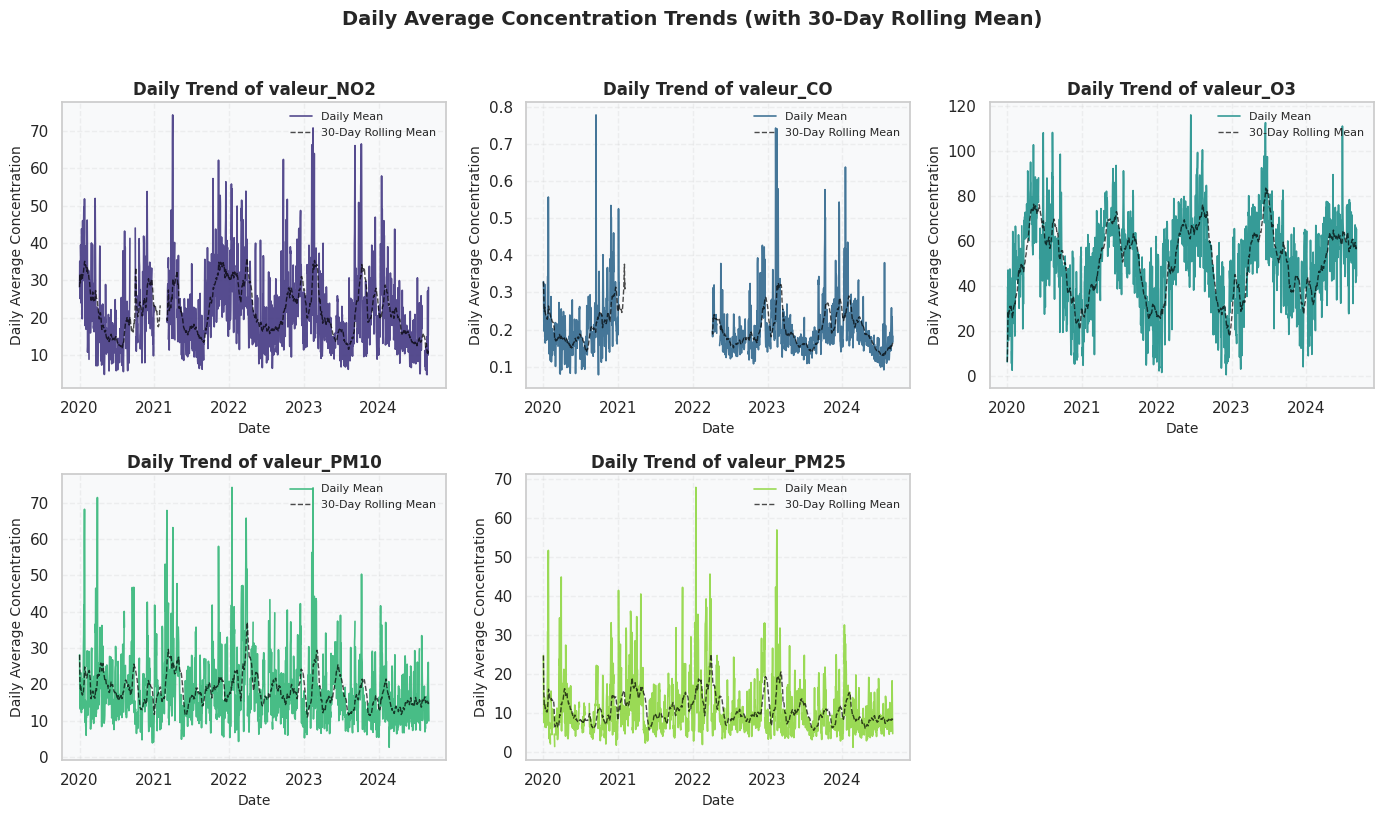

In [13]:
# Resample data to daily means to observe trends
daily_df = train_df[pollutants].resample('D').mean()

# Plot daily trends for each pollutant
plt.figure(figsize=(14, 8))
palette = sns.color_palette("viridis", len(pollutants))

for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    
# Plot daily mean trend
    plt.plot(
        daily_df.index,
        daily_df[pollutant],
        color=palette[i-1],
        linewidth=1.2,
        alpha=0.9,
        label="Daily Mean"
    )
    
# Add 30-day rolling mean for smoother visualization
    plt.plot(
        daily_df[pollutant].rolling(window=30, min_periods=1).mean(),
        color="black",
        linestyle="--",
        linewidth=1.0,
        alpha=0.7,
        label="30-Day Rolling Mean"
    )

# Style setting
    plt.title(f"Daily Trend of {pollutant}", fontsize=12, fontweight="bold", pad=5)
    plt.xlabel("Date", fontsize=10)
    plt.ylabel("Daily Average Concentration", fontsize=10)
    plt.grid(alpha=0.25, linestyle="--")
    plt.gca().set_facecolor("#f8f9fa")
    plt.legend(loc="upper right", fontsize=8, frameon=False)

plt.suptitle("Daily Average Concentration Trends (with 30-Day Rolling Mean)", 
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


NO2: Shows periodic spikes, suggesting seasonal variations. Trends remain stable without major changes over time.

CO: Generally low with occasional spikes, especially in 2021 and 2023, indicating specific pollution events, as mentioned before, a clear gap exists.

O3: Strong seasonal pattern with high peaks, likely influenced by warmer months and sunlight levels.

PM10: Displays intermittent spikes and moderate seasonal patterns, reflecting variable particulate pollution sources.

PM2.5: Similar to PM10 but more volatile, with frequent peaks, indicating sensitivity to different environmental factors.

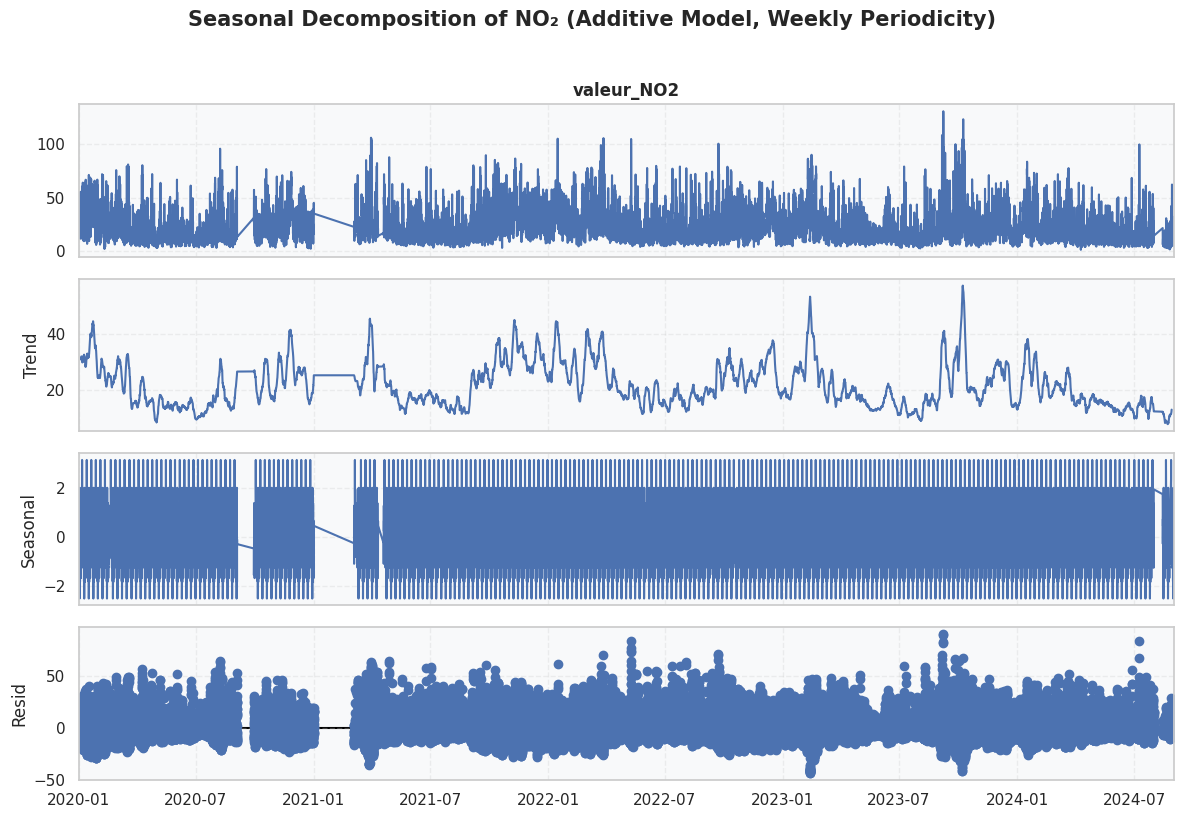

In [14]:
# Seasonal Decomposition for one pollutant (e.g., NO2)
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform decomposition (24*7 = weekly seasonality if hourly data)
decomposition = seasonal_decompose(
    train_df['valeur_NO2'].dropna(),
    model='additive',
    period=24*7
)

# Plot decomposition results
fig = decomposition.plot()
fig.set_size_inches(12, 8)

# --- Style adjustments ---
for ax in fig.axes:
    ax.grid(alpha=0.3, linestyle='--')
    ax.set_facecolor("#f8f9fa")
    ax.title.set_size(12)
    ax.title.set_weight('bold')

plt.suptitle("Seasonal Decomposition of NO₂ (Additive Model, Weekly Periodicity)",
             fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


The seasonal decomposition of NO₂ reveals a clear weekly pattern, consistent with human activity cycles. The trend component indicates a relatively stable long-term level, while the residual captures short-term fluctuations and anomalies.

In [15]:
# Extract date components
train_df['year'] = train_df.index.year
train_df['month'] = train_df.index.month
train_df['day'] = train_df.index.day
train_df['hour'] = train_df.index.hour

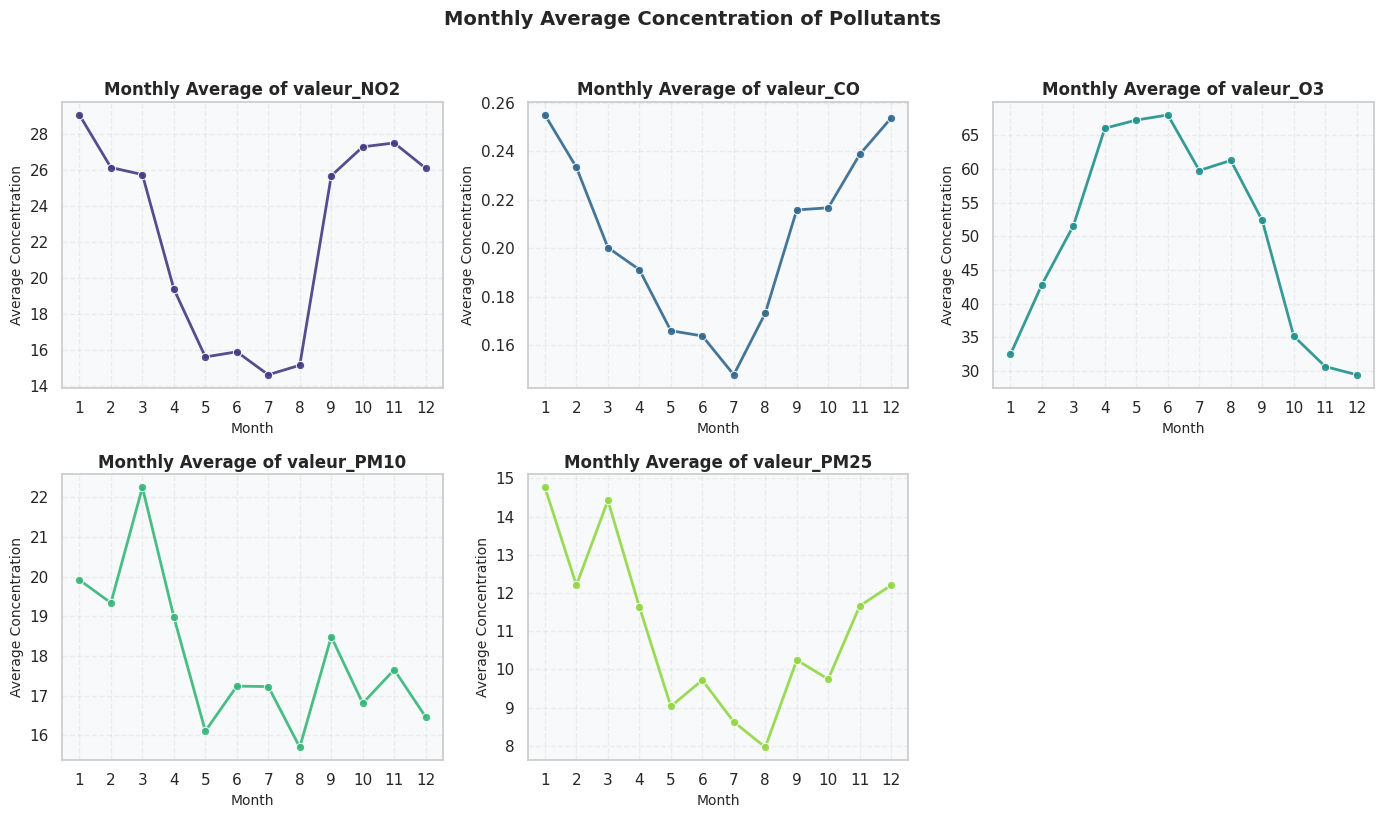

In [16]:
# Monthly average plot for each pollutant
plt.figure(figsize=(14, 8))
palette = sns.color_palette("viridis", len(pollutants))

for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    
    # --- Plot monthly average trend ---
    sns.lineplot(
        data=train_df,
        x='month',
        y=pollutant,
        estimator='mean',
        ci=None,
        color=palette[i-1],
        linewidth=2,
        marker='o',
        alpha=0.9
    )

    # --- Styling ---
    plt.title(f"Monthly Average of {pollutant}", fontsize=12, fontweight="bold", pad=5)
    plt.xlabel("Month", fontsize=10)
    plt.ylabel("Average Concentration", fontsize=10)
    plt.grid(alpha=0.3, linestyle="--")
    plt.gca().set_facecolor("#f8f9fa")
    plt.xticks(range(1, 13))  # ensure 1–12 months on x-axis

plt.suptitle("Monthly Average Concentration of Pollutants", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


**NO2:** Peaks in winter months (January, December) and dips in summer, suggesting higher emissions or lower dispersion in colder months.

**CO:** Follows a similar trend to NO2, with higher levels in winter and lower in summer, likely due to increased heating and combustion activities in colder months.

**O3:** Opposite trend to NO2 and CO, with peaks in late spring and early summer, likely due to sunlight-driven ozone formation, and lower levels in winter.

**PM10:** Highest levels in early spring, then generally lower through the rest of the year, suggesting potential seasonal sources like dust or pollen.

**PM2.5:** Peaks in winter, with lower levels in summer, possibly due to heating emissions in colder months.

Each pollutant shows distinct seasonal patterns likely influenced by weather, sunlight, and human activities.

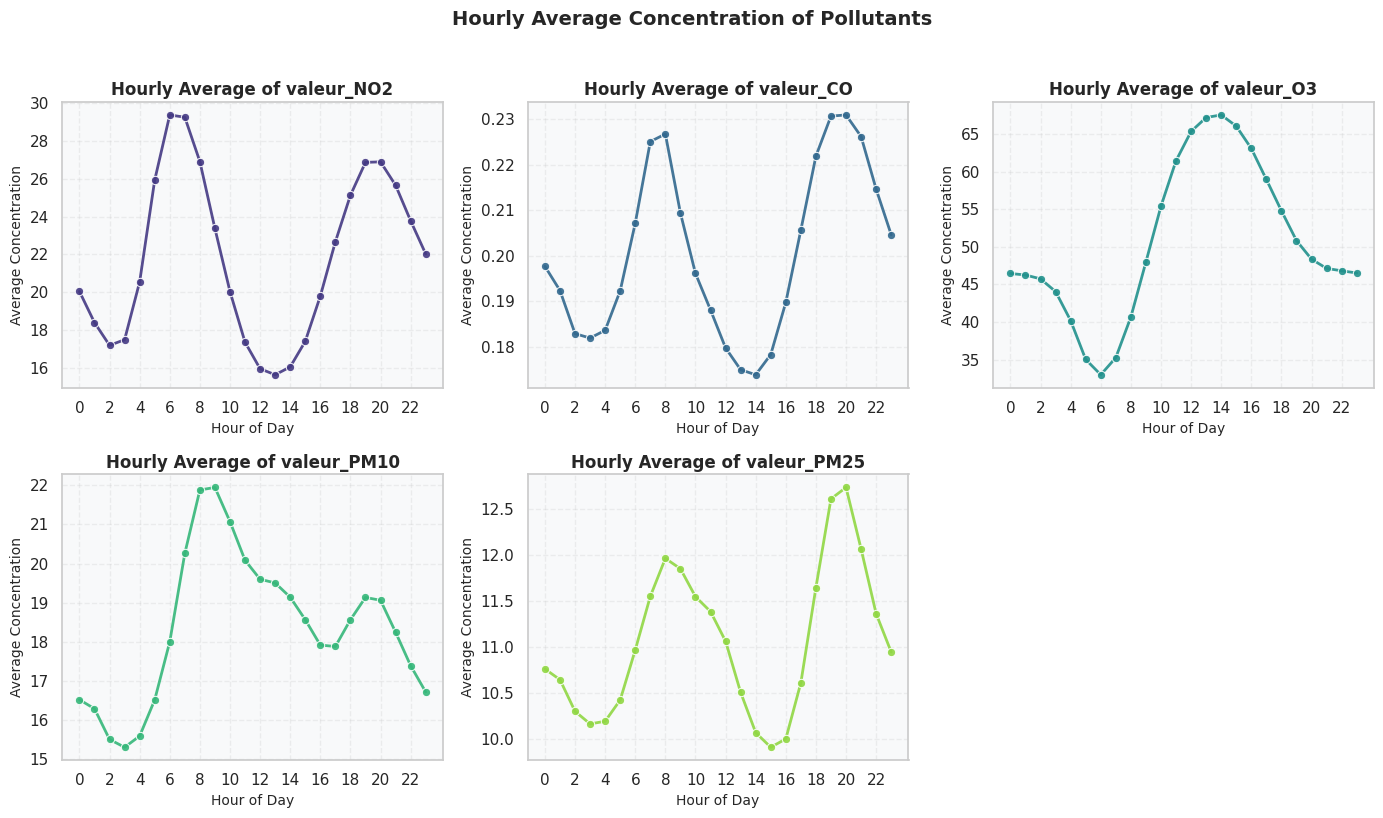

In [17]:
# Hourly average plot for each pollutant
plt.figure(figsize=(14, 8))
palette = sns.color_palette("viridis", len(pollutants))

for i, pollutant in enumerate(pollutants, 1):
    plt.subplot(2, 3, i)
    
    # --- Plot hourly mean trend ---
    sns.lineplot(
        data=train_df,
        x='hour',
        y=pollutant,
        estimator='mean',
        ci=None,
        color=palette[i-1],
        linewidth=2,
        marker='o',
        alpha=0.9
    )

    # --- Style adjustments ---
    plt.title(f"Hourly Average of {pollutant}", fontsize=12, fontweight="bold", pad=5)
    plt.xlabel("Hour of Day", fontsize=10)
    plt.ylabel("Average Concentration", fontsize=10)
    plt.grid(alpha=0.3, linestyle="--")
    plt.gca().set_facecolor("#f8f9fa")
    plt.xticks(range(0, 24, 2))  # show ticks every 2 hours for readability

plt.suptitle("Hourly Average Concentration of Pollutants", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


**NO2:** Peaks in the early morning (around 7 AM) and late evening (around 8 PM), likely linked to rush hour traffic emissions.

**PM2.5:** Follows a similar pattern to NO2, with peaks in the morning and evening, suggesting a strong connection to vehicular emissions.

**PM2.5:** Peaks in the afternoon (around 3 PM), influenced by sunlight, which promotes ozone formation, and dips during nighttime.

**PM2.5:** Shows a morning peak and a smaller increase in the evening, possibly due to human activities like traffic and construction.

**PM2.5:** Peaks in the early morning and late evening, similar to NO2 and CO, suggesting a correlation with combustion-related sources like traffic.

# Preprocessing

1. Date and Time Features
* Extract Date Features: Extract year, month, day, and hour from the timestamp for each entry.
* Cyclic Features: Add cyclic features for hour and month using sine and cosine transformations.
2. Lag and Rolling Features
* Lagged Values: Create lagged features for each pollutant (1, 24, 168 hours to capture short, daily, and weekly patterns).
* Rolling Statistics: Add rolling mean, rolling standard deviation, and rolling min/max features to smooth trends.
3. Handle Missing Values
* Impute Missing Values: Choose and implement a strategy (e.g., forward-fill, backward-fill, interpolation) for missing data in each pollutant.
* Drop or Flag Missing Rows: If a significant portion of the data is missing, consider dropping those rows or creating an indicator feature to mark them.
4. External Weather Data (Optional but Recommended)
* Incorporate Weather Data: If available, obtain weather data for Paris (temperature, humidity, wind speed).
* Merge with Pollutant Data: Align weather data with your time series dataset based on the timestamp.
5. Data Scaling
* Scale Features: Use standard scaling or min-max scaling for numerical features, especially for pollutants and weather variables (if any).
6. Target Preparation
* Prepare Target Variables: Shift the pollutant columns to create target variables aligned with the forecasting horizon (e.g., next hour, next day).
* Split Data: Divide the data into training and validation sets, ensuring the split respects the time sequence.

In [18]:
!pip install meteostat

In [19]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install qolmat

INFO: pip is looking at multiple versions of category-encoders to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 42.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 59.8 MB/s eta 0:00:0000:01:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: category-encoders
    Found existing installation: category_encoders 2.7.0
    Uninstalling category_encoders-2.7.0:
      Successfully uninstalled category_encoders-2.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of th

In [21]:
pip install vacances_scolaires_france

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [22]:
# Import libraries
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from meteostat import Point, Daily
import holidays
from jours_feries_france import JoursFeries
from vacances_scolaires_france import SchoolHolidayDates
import datetime

# Set plot style
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from qolmat.imputations import imputers

**Fix the missing values**

In [23]:
# Handling Missing Values

# Replace inf/-inf with NaN (if any)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Impute missing values (using median as it's robust to outliers)
#imputer = SimpleImputer(strategy='median')
#train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns, index=train_df.index)
train_df.head(2)

,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,year,month,day,hour
id,,,,,,,,,
2020-01-01 00:00:00,42.9,0.718,15.7,73.1,64.4,2020,1,1,0
2020-01-01 01:00:00,33.6,0.587,10.1,74.8,66.0,2020,1,1,1


In [24]:
# find the best way filling: should directly cut some values
cols = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10',
       'valeur_PM25']
def check_filling_result(df=train_df, fixed_df=""):
    for col in cols:
        plt.figure(figsize=(20, 12))

        # First subplot in blue
        plt.subplot(2, 1, 1)  # 2 rows, 1 column, 1st plot
        train_df[col].plot(kind='line', color='blue', title=f"Train Data - Column '{col}' (Blue)")
        plt.xlabel("Index")
        plt.ylabel("Value")

        # Second subplot in red
        plt.subplot(2, 1, 2)  # 2 rows, 1 column, 2nd plot
        fixed_df[col].plot(kind='line', color='red', title="Fixed Train Data - Column '{col}' (Red)")
        plt.xlabel("Index")
        plt.ylabel("Value")

        # Display the plots
        plt.tight_layout()  # Adjust layout to prevent overlap
        plt.show()

In [25]:
import pandas as pd

def consecutive_null_runs(df, target_col, date_col=None):
    """
    Find consecutive NaN runs for `target_col`.
    If `date_col` is None, use the DataFrame index as the date.
    Returns a DataFrame with start_date, end_date, null_num, percentage.
    """
    # choose date series
    dates = df.index if date_col is None else pd.to_datetime(df[date_col])

    s = df[target_col]
    mask = s.isna()
    if not mask.any():
        return pd.DataFrame(columns=["start_date","end_date","null_num","percentage"])

    # group consecutive True blocks
    grp = (mask != mask.shift()).cumsum()
    tmp = pd.DataFrame({"date": dates, "isnull": mask, "grp": grp})

    out = (
        tmp[tmp["isnull"]]
        .groupby("grp")
        .agg(start_date=("date","first"),
             end_date=("date","last"),
             null_num=("date","size"))
        .sort_values("null_num", ascending=False)
    )
    out["percentage"] = out["null_num"] / len(df) * 100
    return out.reset_index(drop=True)


In [26]:
for target in cols:
    print(target)
    display(consecutive_null_runs(train_df, target_col=target, date_col=None).head(5))
    print()

valeur_NO2


,start_date,end_date,null_num,percentage
0,2021-01-01 00:00:00,2021-03-04 11:00:00,1500,3.659340
1,2020-09-03 14:00:00,2020-09-29 13:00:00,624,1.522285
2,2024-07-31 15:00:00,2024-08-14 09:00:00,331,0.807494
3,2021-04-11 02:00:00,2021-04-19 12:00:00,203,0.495231
4,2024-09-01 02:00:00,2024-09-03 22:00:00,69,0.168330



valeur_CO


,start_date,end_date,null_num,percentage
0,2021-01-05 09:00:00,2022-04-06 13:00:00,10949,26.710741
1,2022-04-27 08:00:00,2022-05-11 12:00:00,341,0.831890
2,2022-09-15 17:00:00,2022-09-26 10:00:00,258,0.629406
3,2023-08-11 18:00:00,2023-08-16 11:00:00,114,0.278110
4,2020-03-12 09:00:00,2020-03-16 14:00:00,102,0.248835



valeur_O3


,start_date,end_date,null_num,percentage
0,2020-06-02 19:00:00,2020-06-08 05:00:00,131,0.319582
1,2020-03-08 02:00:00,2020-03-12 10:00:00,105,0.256154
2,2020-08-14 06:00:00,2020-08-17 11:00:00,78,0.190286
3,2020-02-16 17:00:00,2020-02-19 09:00:00,65,0.158571
4,2023-04-13 08:00:00,2023-04-14 12:00:00,29,0.070747



valeur_PM10


,start_date,end_date,null_num,percentage
0,2022-07-13 06:00:00,2022-07-16 23:00:00,90,0.219560
1,2022-07-07 06:00:00,2022-07-10 18:00:00,85,0.207363
2,2022-04-28 12:00:00,2022-05-01 23:00:00,84,0.204923
3,2023-09-08 05:00:00,2023-09-10 22:00:00,66,0.161011
4,2020-08-07 10:00:00,2020-08-09 23:00:00,62,0.151253



valeur_PM25


,start_date,end_date,null_num,percentage
0,2020-07-23 00:00:00,2020-08-12 12:00:00,493,1.202703
1,2020-06-25 06:00:00,2020-07-06 19:00:00,278,0.678198
2,2020-02-19 00:00:00,2020-02-23 21:00:00,118,0.287868
3,2020-02-25 05:00:00,2020-02-27 15:00:00,59,0.143934
4,2020-02-04 09:00:00,2020-02-06 13:00:00,53,0.129297


Conclusion: only keep the data after 2022 june 1

In [27]:
# Ensure DatetimeIndex (safe-guard)
if not isinstance(train_df.index, pd.DatetimeIndex):
    train_df.index = pd.to_datetime(train_df.index)

# Filter by date using the index
train_df = train_df.loc[train_df.index >= pd.Timestamp('2022-06-01')]

# Run consecutive-null analysis using the index as the date
for target in cols:
    print(f"\n{target}")
    result = consecutive_null_runs(train_df, target_col=target, date_col=None)
    display(result.head(5))


valeur_NO2


,start_date,end_date,null_num,percentage
0,2024-07-31 15:00:00,2024-08-14 09:00:00,331,1.669778
1,2024-09-01 02:00:00,2024-09-03 22:00:00,69,0.348081
2,2024-06-25 18:00:00,2024-06-26 22:00:00,29,0.146295
3,2022-10-17 23:00:00,2022-10-18 23:00:00,25,0.126116
4,2024-08-26 13:00:00,2024-08-27 10:00:00,22,0.110982



valeur_CO


,start_date,end_date,null_num,percentage
0,2022-09-15 17:00:00,2022-09-26 10:00:00,258,1.301518
1,2023-08-11 18:00:00,2023-08-16 11:00:00,114,0.575090
2,2023-07-14 01:00:00,2023-07-17 07:00:00,79,0.398527
3,2022-06-28 12:00:00,2022-06-29 12:00:00,25,0.126116
4,2024-02-22 13:00:00,2024-02-23 10:00:00,22,0.110982



valeur_O3


,start_date,end_date,null_num,percentage
0,2023-04-13 08:00:00,2023-04-14 12:00:00,29,0.146295
1,2024-02-22 13:00:00,2024-02-23 10:00:00,22,0.110982
2,2024-07-03 13:00:00,2024-07-04 07:00:00,19,0.095848
3,2022-09-13 15:00:00,2022-09-14 08:00:00,18,0.090804
4,2023-04-27 14:00:00,2023-04-28 06:00:00,17,0.085759



valeur_PM10


,start_date,end_date,null_num,percentage
0,2022-07-13 06:00:00,2022-07-16 23:00:00,90,0.454018
1,2022-07-07 06:00:00,2022-07-10 18:00:00,85,0.428795
2,2023-09-08 05:00:00,2023-09-10 22:00:00,66,0.332947
3,2022-07-17 06:00:00,2022-07-19 01:00:00,44,0.221964
4,2023-07-10 06:00:00,2023-07-12 01:00:00,44,0.221964



valeur_PM25


,start_date,end_date,null_num,percentage
0,2024-02-22 13:00:00,2024-02-23 10:00:00,22,0.110982
1,2022-09-13 15:00:00,2022-09-14 08:00:00,18,0.090804
2,2023-04-27 14:00:00,2023-04-28 06:00:00,17,0.085759
3,2024-08-28 19:00:00,2024-08-29 06:00:00,12,0.060536
4,2022-08-01 21:00:00,2022-08-02 07:00:00,11,0.055491


In [28]:
#downgrade qolmat to make sure the compatibility
!pip install qolmat==0.1.8 --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 36.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: qolmat
    Found existing installation: qolmat 0.1.10
    Uninstalling qolmat-0.1.10:
      Successfully uninstalled qolmat-0.1.10


In [29]:
# ---- Robust Comparator run: normalize attributes to avoid 'list'.get error ----
from joblib import parallel_backend
from qolmat.benchmark import comparator, missing_patterns
from qolmat.imputations import imputers
import inspect
import numpy as np
import pandas as pd

# 0) ensure numeric columns only
if not isinstance(train_df.index, pd.DatetimeIndex):
    train_df.index = pd.to_datetime(train_df.index)
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
try:
    cols = [c for c in cols if c in numeric_cols] or numeric_cols
except NameError:
    cols = numeric_cols
df_eval = train_df[cols].copy()

# 1) imputers (your setup)
imputer_interpol = imputers.ImputerInterpolation(method="linear")
imputer_res      = imputers.ImputerResiduals(period=24, model_tsa="additive")
imputer_mce      = imputers.ImputerMICE()
imputer_em       = imputers.ImputerEM(columnwise=False)
imputer_locf     = imputers.ImputerLOCF()
imputers_dict = {
    "interpolation": imputer_interpol,
    "residual":      imputer_res,
    "mce":           imputer_mce,
    "em":            imputer_em,
    "locf":          imputer_locf,
}

# 2) hole generator
# generator_holes = missing_patterns.EmpiricalHoleGenerator(n_splits=4, ratio_masked=0.10)

# fast mode
small_df = train_df[cols].head(500).copy()  # first 500 rows
small_imputers = {
    "interpolation": imputers.ImputerInterpolation(method="linear"),
    "locf": imputers.ImputerLOCF(),
}

generator_holes = missing_patterns.EmpiricalHoleGenerator(n_splits=1, ratio_masked=0.02)

# 3) try to build, then normalize attributes
comp = None

for build in (
    lambda: comparator.Comparator(imputers_dict, cols,
                                  generator_holes=generator_holes, metrics=["mae"], dict_config_opti={}),
    lambda: comparator.Comparator(imputers_dict, generator_holes, cols, ["mae"]),
    lambda: comparator.Comparator(imputers_dict, generator_holes, cols),
    lambda: comparator.Comparator(imputers_dict, generator_holes, None, cols),
    lambda: comparator.Comparator(imputers_dict), 
):
    try:
        comp = build()
        break
    except TypeError:
        continue

if comp is None:
    raise RuntimeError("Could not instantiate qolmat.Comparator with known signatures.")

# ---- Normalize ----
# columns
if not hasattr(comp, "columns") or comp.columns is None:
    comp.columns = cols
# hole generator
if not hasattr(comp, "generator_holes") or comp.generator_holes is None:
    comp.generator_holes = generator_holes
# dict_config_opti must be a dict
if not hasattr(comp, "dict_config_opti") or not isinstance(comp.dict_config_opti, dict):
    comp.dict_config_opti = {}
# metrics
if hasattr(comp, "metrics"):
    comp.metrics = ["mae"]

# 4) run (no subprocesses)
with parallel_backend("threading", n_jobs=1):
    try:
        results = comp.compare(df_eval, use_parallel=False)
    except TypeError:
        try:
            results = comp.compare(df_eval, n_jobs=1)
        except TypeError:
            results = comp.compare(df_eval)

# 5) display
try:
    display(results.style.highlight_min(color="lightsteelblue", axis=1))
except Exception:
    print(results)

# 6) best per column
try:
    best_per_col = results.idxmin(axis=0).to_dict()
    print("\nBest method per column:")
    for col, m in best_per_col.items():
        print(f"  {col}: {m}")
except Exception:
    pass



Best method per column:
  interpolation: ('mae', 'valeur_CO')
  residual: ('mae', 'valeur_CO')
  mce: ('mae', 'valeur_CO')
  em: ('mae', 'valeur_CO')
  locf: ('mae', 'valeur_CO')


conclusion:
NO2: em
CO: mce
O3: residual
PM10: em
PM25: residual

In [30]:
# --- Keep the original 6 columns, as in the baseline notebook ---
pollutants = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']

# If 'id' is the DatetimeIndex, restore it as a column
if 'id' not in train_df.columns:
    train_df = train_df.reset_index().rename(columns={'index': 'id'})

# Keep only the original 6 columns and the original order
train_df = train_df[['id'] + pollutants].copy()
train_df['id'] = pd.to_datetime(train_df['id'])

# Work on a copy (do NOT touch train_df)
fixed_train_df = train_df.copy()

# --- Define imputers (qolmat) ---
from qolmat.imputations import imputers
imputer_mce = imputers.ImputerMICE()
imputer_res = imputers.ImputerResiduals(period=24, model_tsa="additive")  # hourly data -> daily seasonality

# --- Column-wise imputation (close to the original style) ---
# Best mapping you confirmed / original note:
# CO -> MICE, O3 -> Residual, PM25 -> Residual, NO2 -> MICE (avoid negatives), PM10 -> MICE (avoid negatives)

fixed_train_df['valeur_CO']   = imputer_mce.fit_transform(train_df[['valeur_CO']])
fixed_train_df['valeur_O3']   = imputer_res.fit_transform(train_df[['valeur_O3']])
fixed_train_df['valeur_PM25'] = imputer_res.fit_transform(train_df[['valeur_PM25']])

# As the original comment: use MICE for NO2 and PM10 to avoid many negative values
fixed_train_df['valeur_NO2']  = imputer_mce.fit_transform(train_df[['valeur_NO2']])
fixed_train_df['valeur_PM10'] = imputer_mce.fit_transform(train_df[['valeur_PM10']])

# (Optional) quick sanity checks
print("NaN counts after imputation:\n", fixed_train_df[pollutants].isna().sum())
print("\nMin values after imputation:\n", fixed_train_df[pollutants].min())
fixed_train_df.head()


NaN counts after imputation:
 valeur_NO2     0
valeur_CO      0
valeur_O3      0
valeur_PM10    0
valeur_PM25    0
dtype: int64

Min values after imputation:
 valeur_NO2     1.100
valeur_CO      0.074
valeur_O3     -1.900
valeur_PM10    0.500
valeur_PM25    0.300
dtype: float64


,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25
0,2022-06-01 00:00:00,16.4,0.148,67.4,10.2,4.1
1,2022-06-01 01:00:00,12.3,0.140,71.9,15.7,5.2
2,2022-06-01 02:00:00,12.1,0.140,69.2,8.4,3.5
3,2022-06-01 03:00:00,24.9,0.155,51.0,11.8,4.9
4,2022-06-01 04:00:00,35.2,0.190,38.2,16.0,5.8


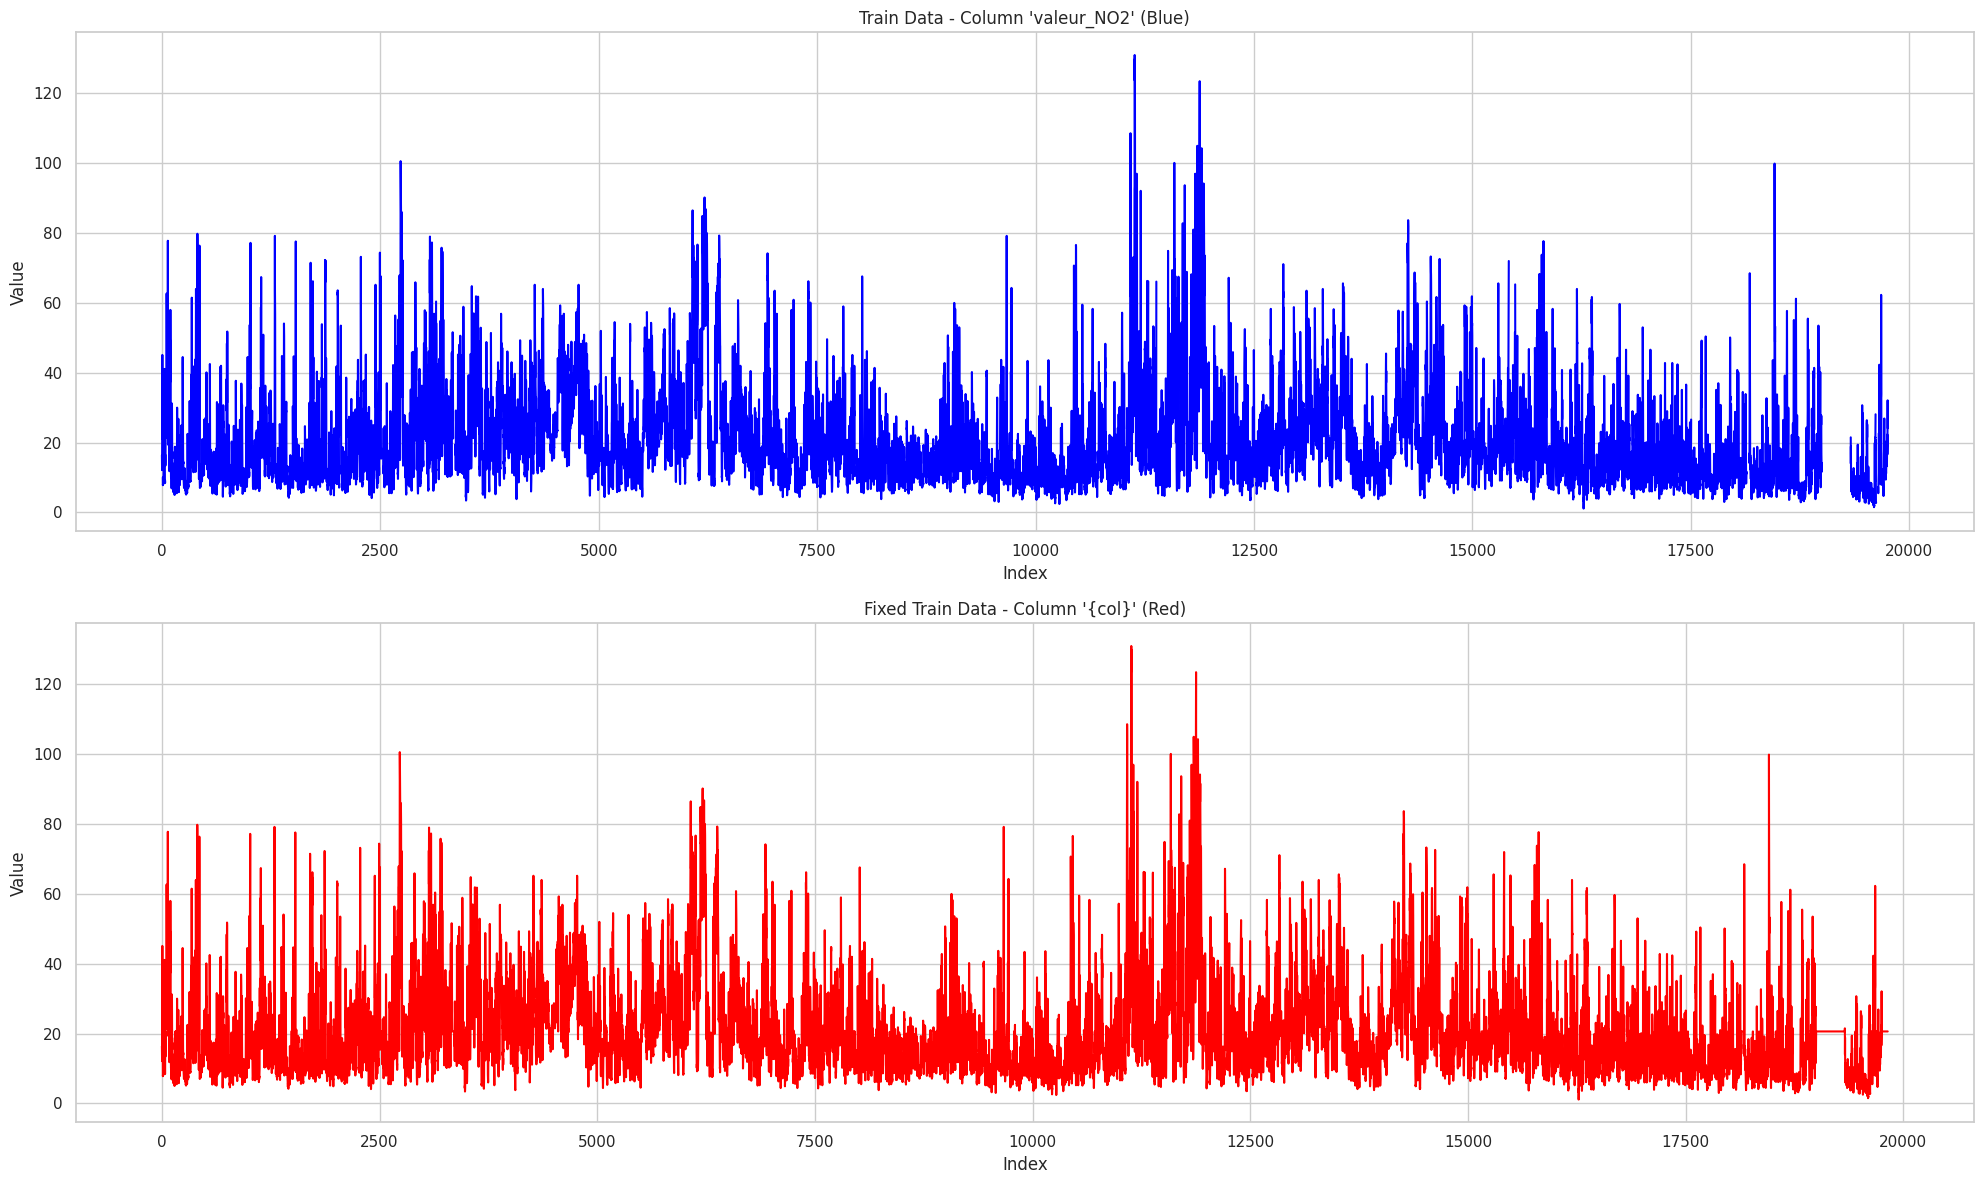

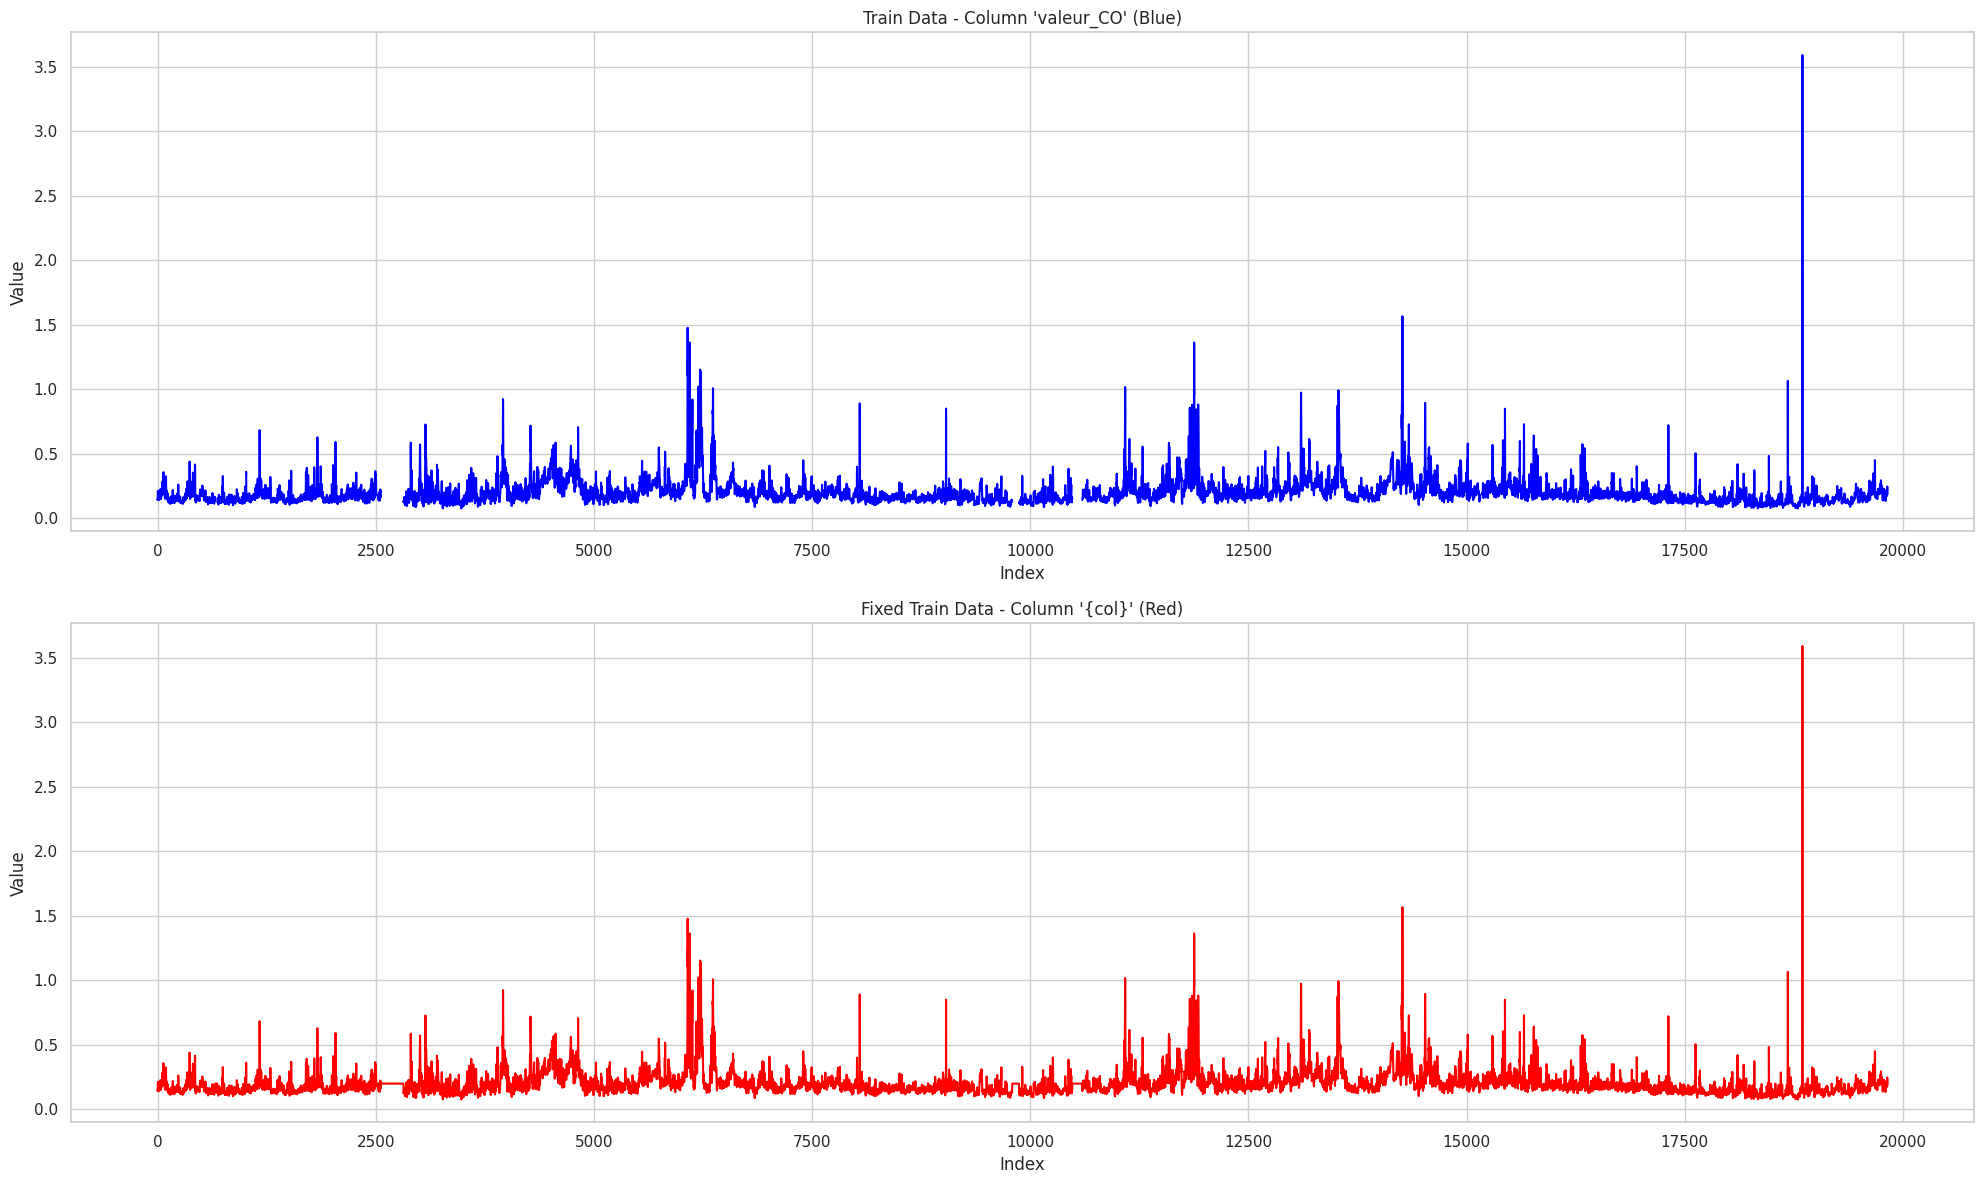

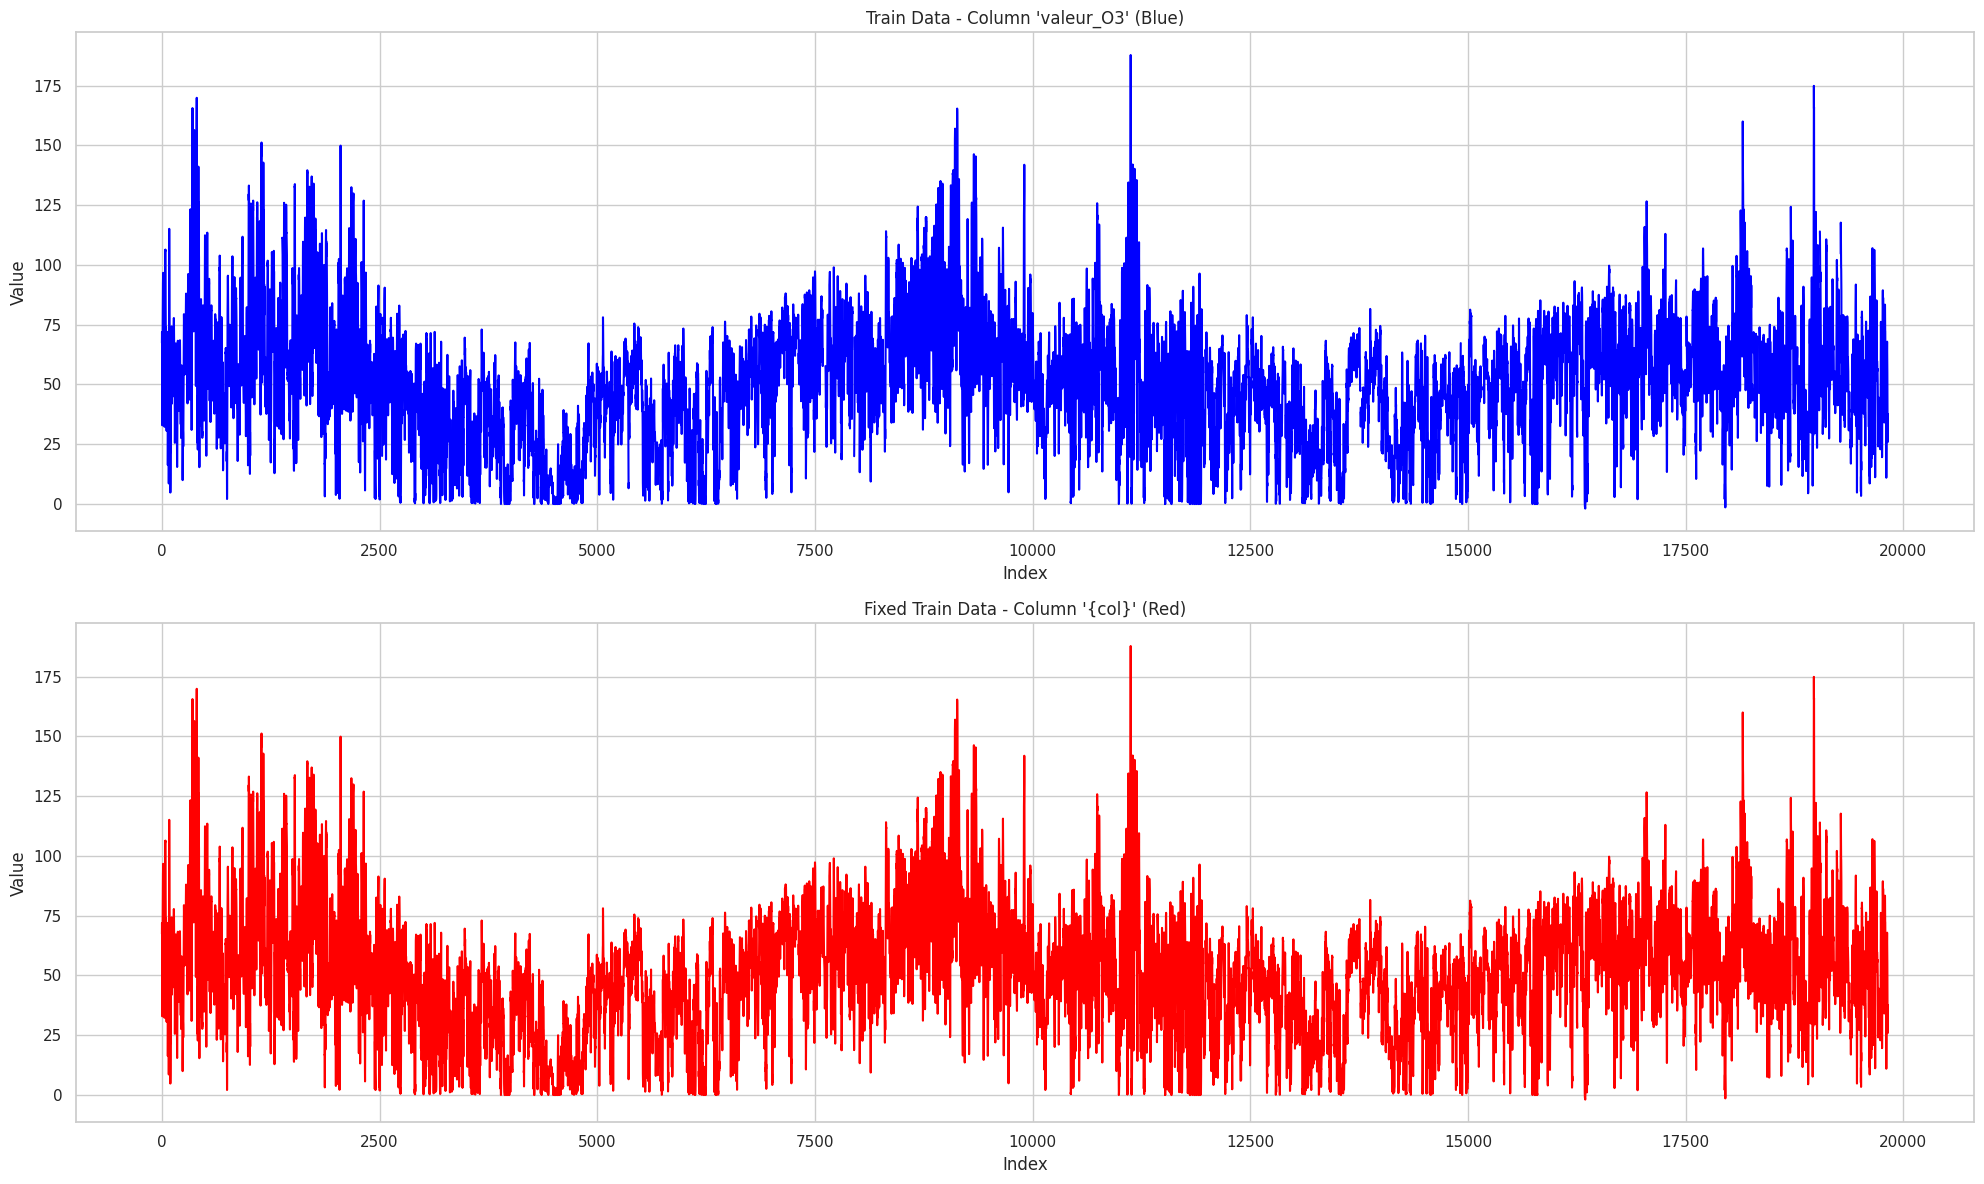

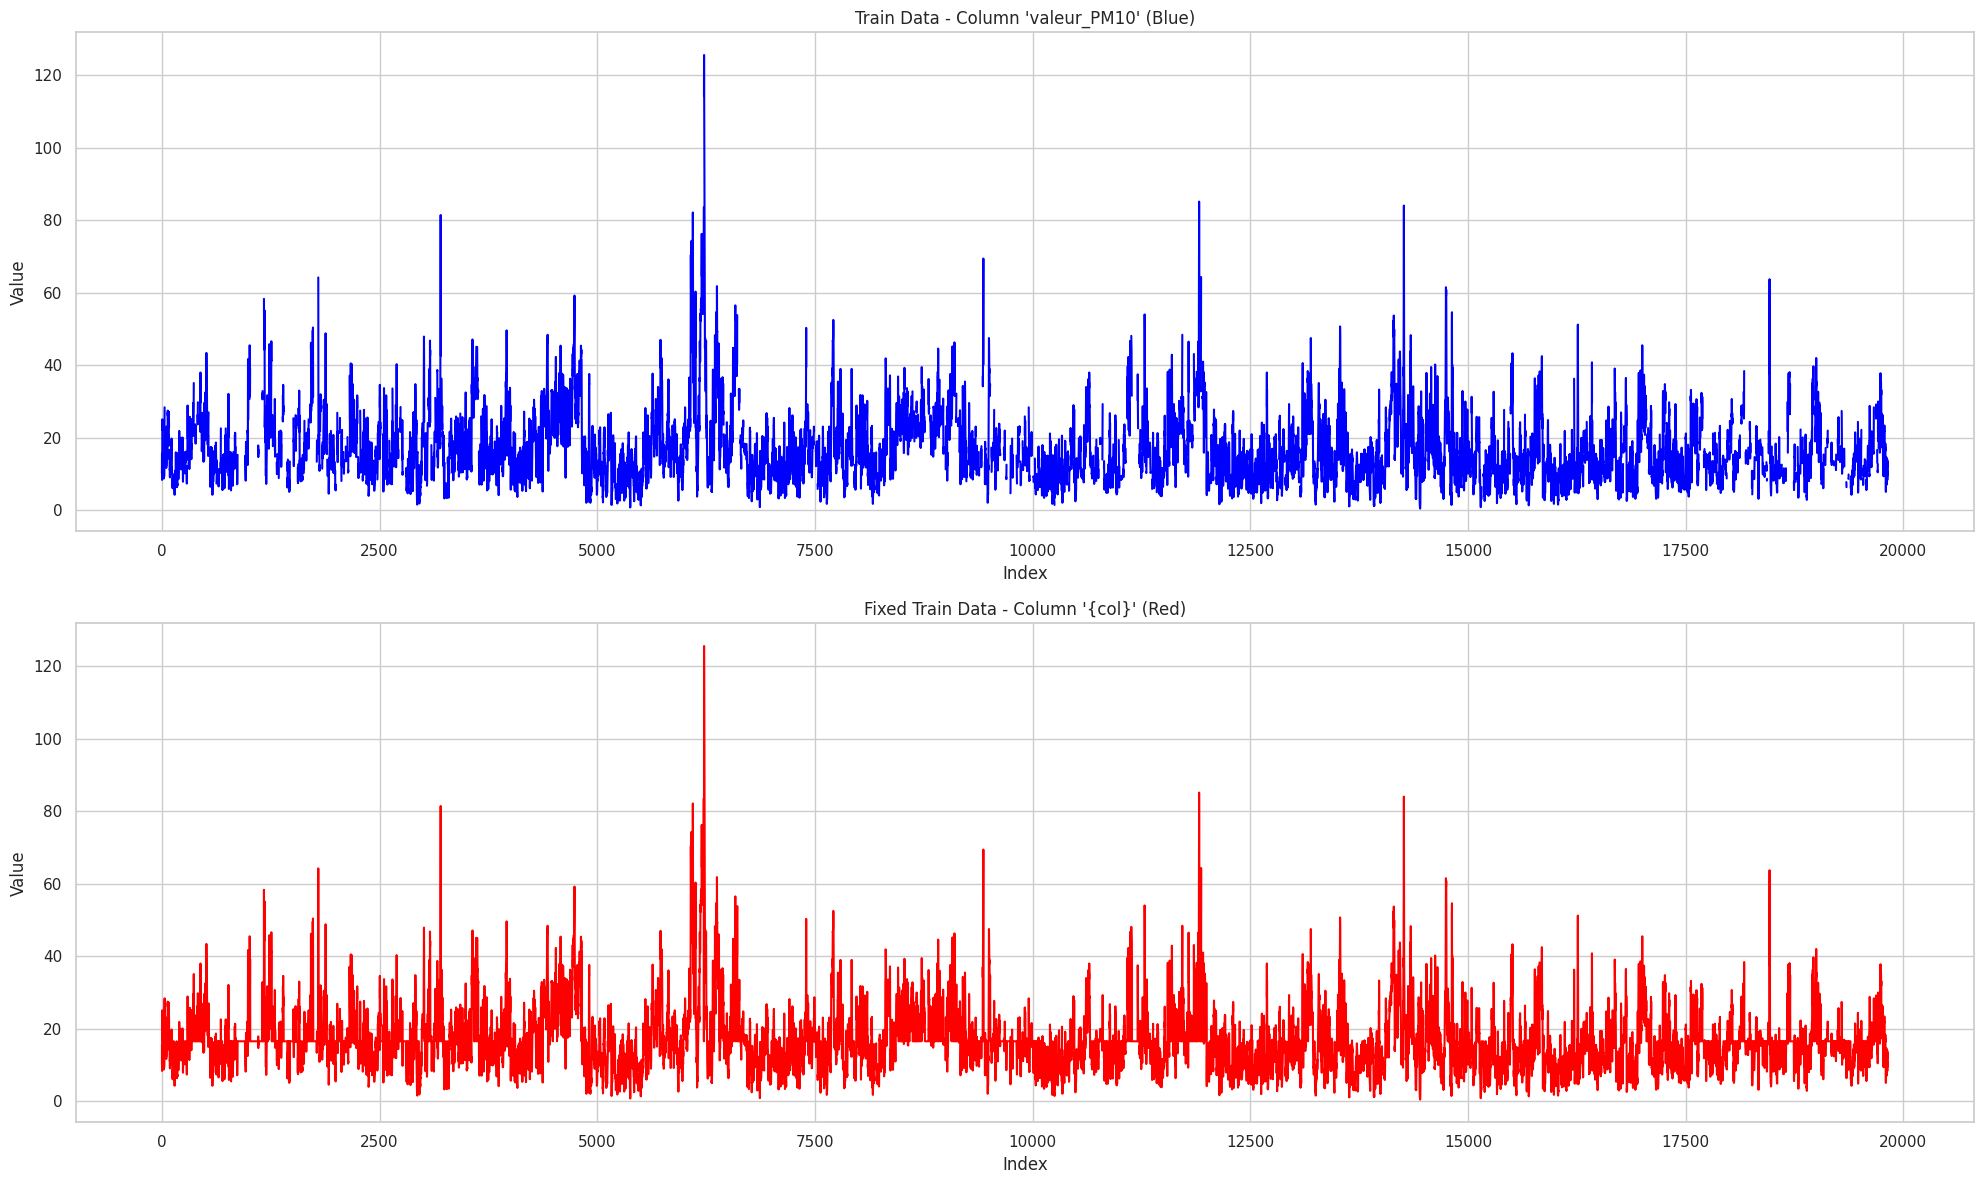

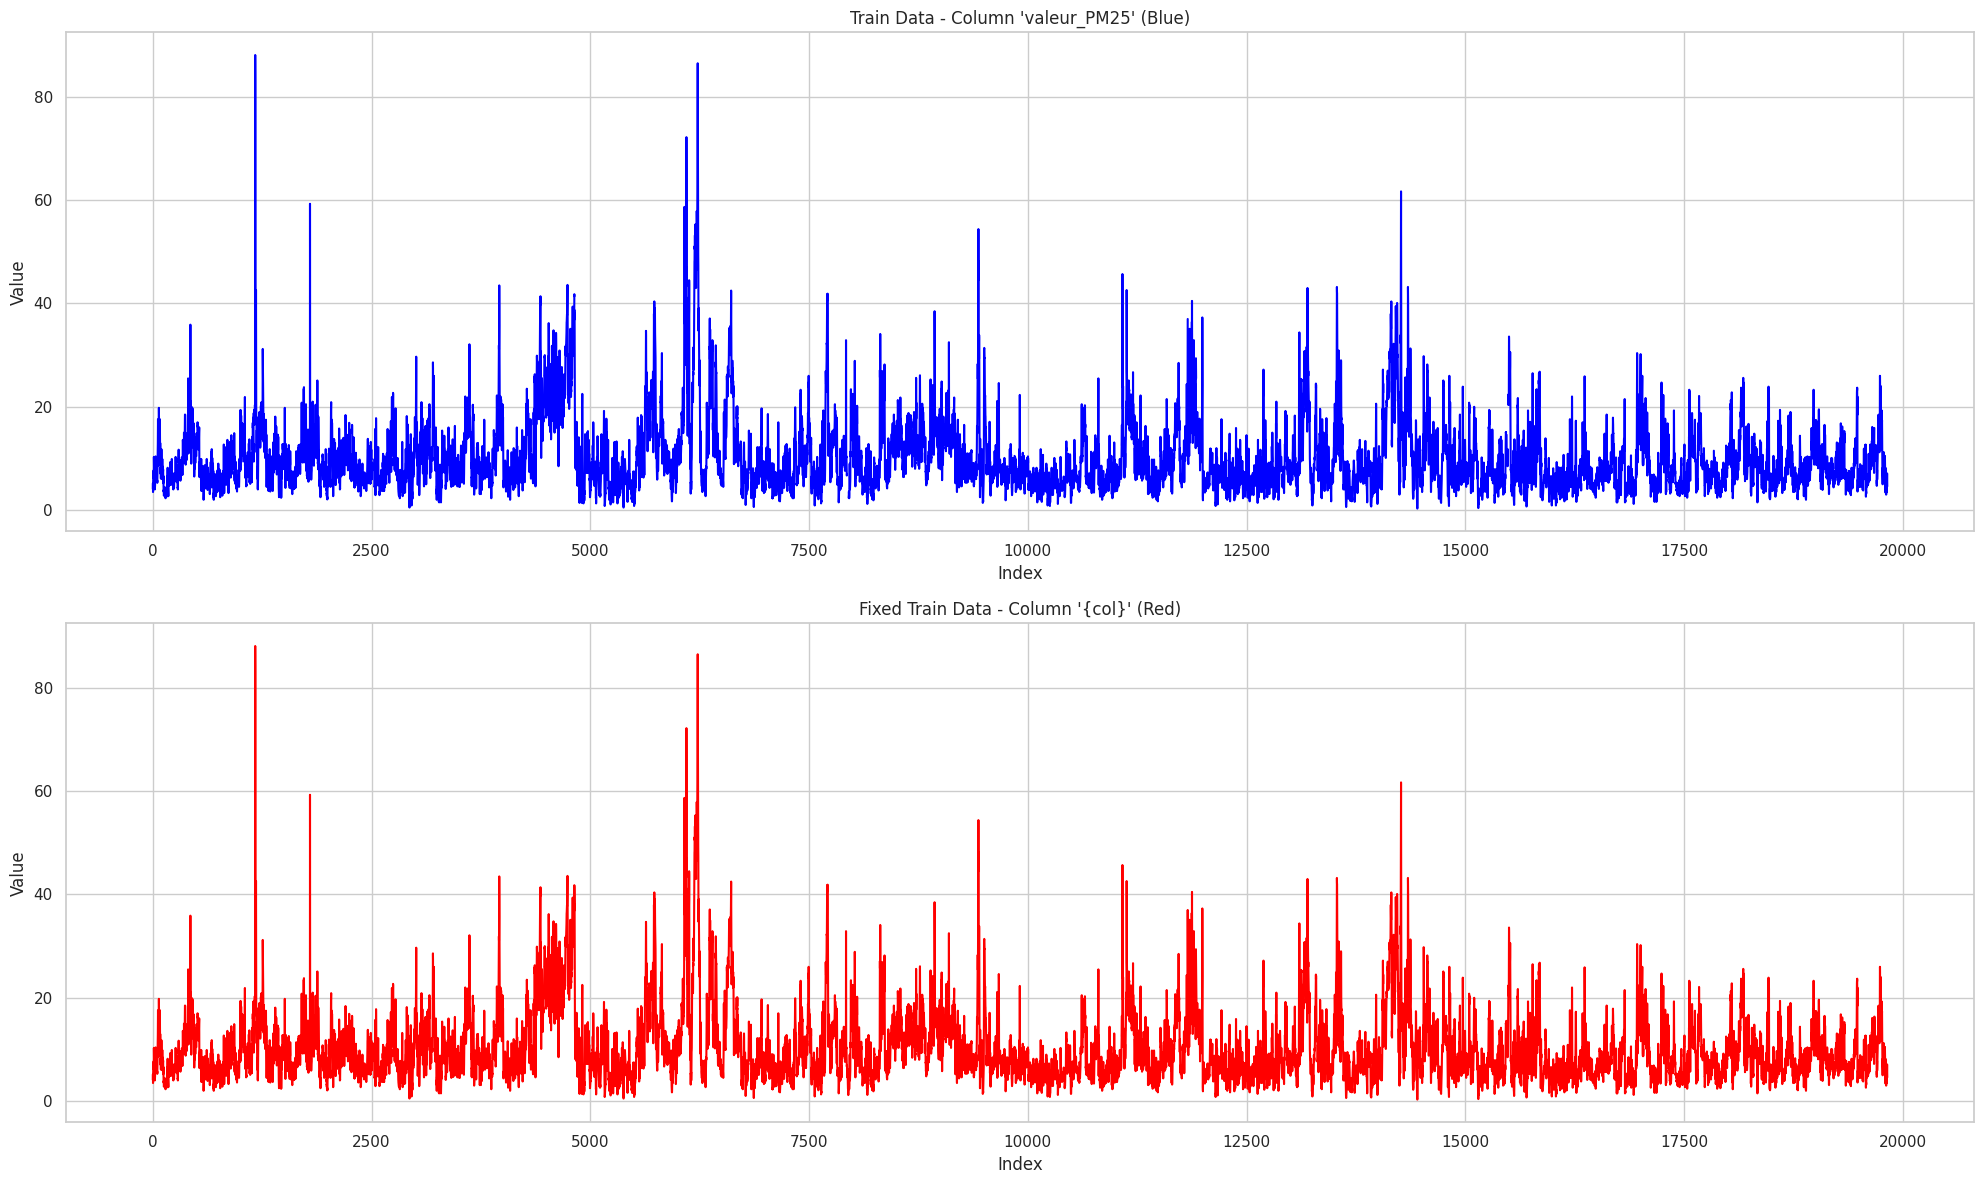

In [31]:
check_filling_result(df=train_df, fixed_df=fixed_train_df)

Improved

In [32]:
m = fixed_train_df[cols]<0
m.sum()

valeur_NO2      0
valeur_CO       0
valeur_O3      10
valeur_PM10     0
valeur_PM25     0
dtype: int64

there's negative values in O3, however, according to the figure above, they are quite close to 0, we directly set to 0

In [34]:
fixed_train_df.loc[fixed_train_df['valeur_O3'] < 0, 'valeur_O3'] = 0

In [35]:
fixed_train_df.to_csv("/kaggle/working/fixed_train.csv", index=False)

In [ ]:
# # Scaling/Normalization

# # Select features for scaling (all pollutant columns and lags)
# scaler = StandardScaler()
# pollutant_columns = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25'] 
# pollutant_columns = pollutant_columns + [f'{col}_lag_{lag}' for col in pollutant_columns for lag in lags]
# train_df[pollutant_columns] = scaler.fit_transform(train_df[pollutant_columns])

**Weather**

In [ ]:
from meteostat import Point, Daily
from datetime import datetime

# train_df['id'] = pd.to_datetime(train_df['id'])
# train_df = train_df.set_index('id')

start_date = train_df.index.min()
end_date = train_df.index.max()

paris = Point(48.8566, 2.3522)

weather_data = Daily(paris, start_date, end_date)
weather_data = weather_data.fetch()

print(weather_data.head())

In [37]:
# Reset index in `weather_data` to use the date as a regular column
weather_data = weather_data.reset_index()
weather_data['weather_time'] = weather_data['time'].dt.floor('D')  # Convert to daily frequency

train_df = train_df.reset_index()
train_df['air_quality_time'] = train_df['id'].dt.floor('D')

# Merge the weather data with your air quality data
merged_df = pd.merge(train_df, weather_data, left_on='air_quality_time', right_on='weather_time', how='left')

# Drop unnecessary columns and clean up
merged_df = merged_df.drop(columns=['air_quality_time', 'weather_time'])

# Save the combined DataFrame to a new CSV file
merged_df.to_csv('/kaggle/working/train_with_weather.csv', index=False)

In [38]:
merged_df

,index,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,0,2022-06-01 00:00:00,16.4,0.148,67.4,10.2,4.1,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN
1,1,2022-06-01 01:00:00,12.3,0.140,71.9,15.7,5.2,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN
2,2,2022-06-01 02:00:00,12.1,0.140,69.2,8.4,3.5,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN
3,3,2022-06-01 03:00:00,24.9,0.155,51.0,11.8,4.9,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN
4,4,2022-06-01 04:00:00,35.2,0.190,38.2,16.0,5.8,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19818,19818,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN
19819,19819,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN
19820,19820,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN
19821,19821,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN


**French Holidays**

In [39]:
# Initialize SchoolHolidayDates
d = SchoolHolidayDates()

# Collect holiday dates for Zone C from 2020 to 2024
holiday_list = []
for year in range(2020, 2025):  # Loop through each year
    holidays_for_year = d.holidays_for_year_and_zone(year, 'C')
    for date in holidays_for_year.keys():
        holiday_list.append({'holiday_date': pd.to_datetime(date), 'is_holiday_zone_c': True})

# Create a DataFrame from the collected holiday dates
holiday_dates_zone_c = pd.DataFrame(holiday_list)

In [40]:
# Check that holiday_dates_zone_c has the 'is_holiday_zone_c' column
print(holiday_dates_zone_c.columns)  # Should include 'holiday_date' and 'is_holiday_zone_c'

# Merge holiday information with train data
merged_df_2 = pd.merge(merged_df, holiday_dates_zone_c, left_on='time', right_on='holiday_date', how='left')

# If 'is_holiday_zone_c' is missing after the merge, default to False
if 'is_holiday_zone_c' not in merged_df_2.columns:
    merged_df_2['is_holiday_zone_c'] = False
else:
    # Fill NaN in 'is_holiday_zone_c' with False
    merged_df_2['is_holiday_zone_c'] = merged_df_2['is_holiday_zone_c'].fillna(False)

# Drop unnecessary columns
merged_df_2 = merged_df_2.drop(columns=['air_quality_time', 'holiday_date','index'], errors='ignore')

# Display the merged DataFrame
merged_df_2

Index(['holiday_date', 'is_holiday_zone_c'], dtype='object')


,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c
0,2022-06-01 00:00:00,16.4,0.148,67.4,10.2,4.1,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False
1,2022-06-01 01:00:00,12.3,0.140,71.9,15.7,5.2,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False
2,2022-06-01 02:00:00,12.1,0.140,69.2,8.4,3.5,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False
3,2022-06-01 03:00:00,24.9,0.155,51.0,11.8,4.9,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False
4,2022-06-01 04:00:00,35.2,0.190,38.2,16.0,5.8,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19818,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False
19819,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False
19820,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False
19821,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False


**Jours Feries**

In [41]:
# Initialize French holidays for the range of years needed
france_holidays = holidays.France(years=range(2020, 2025))

# Assume merged_df_2 is already created and has an 'id' column with datetime values
# Convert 'id' to date-only format for easier holiday matching
merged_df_2['date_only'] = merged_df_2['time'].dt.floor('D')

# Add a new column in merged_df_2 to indicate if each date is a public holiday in France
merged_df_2['is_public_holiday'] = merged_df_2['date_only'].apply(lambda date: date in france_holidays)

# Create merged_df_3 by dropping the 'date_only' column after merging the holiday information
merged_df_3 = merged_df_2.drop(columns=['date_only'])

# Display the final merged DataFrame
merged_df_3

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c,is_public_holiday
0,2022-06-01 00:00:00,16.4,0.148,67.4,10.2,4.1,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False
1,2022-06-01 01:00:00,12.3,0.140,71.9,15.7,5.2,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False
2,2022-06-01 02:00:00,12.1,0.140,69.2,8.4,3.5,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False
3,2022-06-01 03:00:00,24.9,0.155,51.0,11.8,4.9,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False
4,2022-06-01 04:00:00,35.2,0.190,38.2,16.0,5.8,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19818,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False,False
19819,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False,False
19820,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False,False
19821,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False,False


**Lockdown**

In [42]:
lockdown_periods = [
    (pd.Timestamp(year=2020, month=3, day=12).date(), pd.Timestamp(year=2020, month=5, day=10).date()),
    (pd.Timestamp(year=2020, month=10, day=14).date(), pd.Timestamp(year=2020, month=12, day=10).date()),
    (pd.Timestamp(year=2021, month=3, day=31).date(), pd.Timestamp(year=2021, month=5, day=2).date())
]

# Add a 'lockdown' column with True if the date falls within any lockdown period, False otherwise
merged_df_3['lockdown'] = merged_df_3['time'].apply(
    lambda i: any(start <= i.date() <= end for start, end in lockdown_periods)
)

# Display the modified DataFrame
merged_df_3

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c,is_public_holiday,lockdown
0,2022-06-01 00:00:00,16.4,0.148,67.4,10.2,4.1,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False
1,2022-06-01 01:00:00,12.3,0.140,71.9,15.7,5.2,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False
2,2022-06-01 02:00:00,12.1,0.140,69.2,8.4,3.5,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False
3,2022-06-01 03:00:00,24.9,0.155,51.0,11.8,4.9,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False
4,2022-06-01 04:00:00,35.2,0.190,38.2,16.0,5.8,2022-06-01,16.8,11.3,21.8,0.0,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19818,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
19819,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
19820,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False
19821,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,0.6,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False


**Weekend**

In [45]:
# Add a new column indicating if the date is a weekend day ("Saturday" or "Sunday") or not
merged_df_3['is_weekend'] = merged_df_3['time'].apply(lambda x: x.weekday() >= 5)

# Display the modified DataFrame
merged_df_3

,id,valeur_NO2,valeur_CO,valeur_O3,valeur_PM10,valeur_PM25,time,tavg,tmin,tmax,...,snow,wdir,wspd,wpgt,pres,tsun,is_holiday_zone_c,is_public_holiday,lockdown,is_weekend
0,2022-06-01 00:00:00,16.4,0.148,67.4,10.2,4.1,2022-06-01,16.8,11.3,21.8,...,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False,False
1,2022-06-01 01:00:00,12.3,0.140,71.9,15.7,5.2,2022-06-01,16.8,11.3,21.8,...,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False,False
2,2022-06-01 02:00:00,12.1,0.140,69.2,8.4,3.5,2022-06-01,16.8,11.3,21.8,...,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False,False
3,2022-06-01 03:00:00,24.9,0.155,51.0,11.8,4.9,2022-06-01,16.8,11.3,21.8,...,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False,False
4,2022-06-01 04:00:00,35.2,0.190,38.2,16.0,5.8,2022-06-01,16.8,11.3,21.8,...,NaN,337.0,8.9,31.0,1016.6,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19818,2024-09-03 18:00:00,NaN,0.222,55.1,12.0,5.3,2024-09-03,20.0,18.2,21.6,...,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False,False
19819,2024-09-03 19:00:00,NaN,0.245,48.2,13.4,7.0,2024-09-03,20.0,18.2,21.6,...,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False,False
19820,2024-09-03 20:00:00,NaN,0.234,44.5,12.4,7.1,2024-09-03,20.0,18.2,21.6,...,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False,False
19821,2024-09-03 21:00:00,NaN,0.225,25.9,10.6,5.4,2024-09-03,20.0,18.2,21.6,...,NaN,239.0,8.2,28.0,1015.1,NaN,False,False,False,False


In [48]:
# === Create cyclical train/test datasets (robust to missing 'id') ===
import numpy as np
import pandas as pd

# 1) read train with weather
train_with_weather = pd.read_csv('/kaggle/working/train_with_weather.csv')

# 2) read test source (with or without weather)
try:
    test_with_weather = pd.read_csv('/kaggle/working/test_with_weather.csv')
    test_source = test_with_weather
except FileNotFoundError:
    test_source = test_df.copy()

def ensure_id_column(df, prefer='id'):
    """
    Make sure there is an 'id' column in df.
    Strategy:
      - if 'id' in columns: do nothing
      - elif 'time' in columns: rename 'time' -> 'id'
      - elif index seems meaningful: move index to a column named 'id'
      - elif common merge leftovers exist: pick one and rename
      - else: force reset_index as 'id'
    """
    df = df.copy()
    if prefer in df.columns:
        return df

    # common alternates
    for alt in ['time', 'datetime', 'date', 'Date', 'id_x', 'id_y']:
        if alt in df.columns:
            df = df.rename(columns={alt: prefer})
            return df

    # index may be the id
    if df.index.name == prefer:
        df = df.reset_index()
        return df

    # last resort: reset index -> 'id'
    df = df.reset_index().rename(columns={'index': prefer})
    return df


train_with_weather = ensure_id_column(train_with_weather, prefer='id')
test_source        = ensure_id_column(test_source,        prefer='id')

def add_cyclical_features(df, id_col='id'):
    df = df.copy()
    dt = pd.to_datetime(df[id_col])
    df['hour_sin']   = np.sin(2*np.pi*dt.dt.hour/24)
    df['hour_cos']   = np.cos(2*np.pi*dt.dt.hour/24)
    df['dow_sin']    = np.sin(2*np.pi*dt.dt.dayofweek/7)
    df['dow_cos']    = np.cos(2*np.pi*dt.dt.dayofweek/7)
    df['month_sin']  = np.sin(2*np.pi*dt.dt.month/12)
    df['month_cos']  = np.cos(2*np.pi*dt.dt.month/12)
    df['doy_sin']    = np.sin(2*np.pi*dt.dt.dayofyear/365.25)
    df['doy_cos']    = np.cos(2*np.pi*dt.dt.dayofyear/365.25)
    return df

# 3) add cyclical features
train_cyc = add_cyclical_features(train_with_weather, id_col='id')
test_cyc  = add_cyclical_features(test_source,        id_col='id')

# 4) save
train_cyc.to_csv('/kaggle/working/final_train_cyclical.csv', index=True)
test_cyc.to_csv('/kaggle/working/final_test_cyclical.csv', index=True)

print("Saved cyclical datasets:")
print(" - /kaggle/working/final_train_cyclical.csv", train_cyc.shape)
print(" - /kaggle/working/final_test_cyclical.csv",  test_cyc.shape)
print("Columns check — train has id:", 'id' in train_cyc.columns, "| test has id:", 'id' in test_cyc.columns)


Saved cyclical datasets:
 - /kaggle/working/final_train_cyclical.csv (19823, 26)
 - /kaggle/working/final_test_cyclical.csv (504, 9)
Columns check — train has id: True | test has id: True


In [49]:
# === Load cyclical data and split ===
import pandas as pd

train_processed = pd.read_csv('/kaggle/working/final_train_cyclical.csv', index_col=0)
test_processed  = pd.read_csv('/kaggle/working/final_test_cyclical.csv', index_col=0)

target_columns = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']

X_train = train_processed.drop(columns=target_columns)
y_train = train_processed[target_columns]

missing_cols = [c for c in X_train.columns if c not in test_processed.columns]
for c in missing_cols:
    test_processed[c] = 0.0

X_test = test_processed[X_train.columns].reset_index(drop=True)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:",  X_test.shape)

X_train: (19823, 21)
y_train: (19823, 5)
X_test: (504, 21)


Need to do the same preprocessing for X_test to get the same columns as X_train

# Modelling
**Baseline Model**
* Baseline (Naive) Model: Implement a simple baseline model, such as predicting the last known value or average to set a benchmark for evaluation.


**Model Selection and Training**
* ARIMA / Exponential Smoothing
* LSTM/GRU
* Other Deep Learning

**Hyperparameter Tuning**
* Grid/Random Search: Perform hyperparameter tuning using time-series cross-validation ().


**Model Evaluation**
* Define Evaluation Metrics: MAE
* Evaluate on Validation Set: Assess each model’s performance on the validation set and compare it with the baseline.
* Residual Analysis: Plot and analyze residuals to check for patterns or biases.


**Forecasting**
* Make Predictions: Generate predictions for the future time points provided in test.csv.

In [50]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.3/60.3 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta

In [52]:
!pip -q install --no-deps "torch==2.6.0" "torchvision==0.21.0" "torchaudio==2.6.0"
!pip -q install --no-deps "pytorch-lightning==2.4.0" "torchmetrics==1.5.1"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 11.9 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 32.1 MB/s eta 0:00:00


In [5]:
import sys, subprocess, pkgutil

print("PYTHON =", sys.executable)
subprocess.check_call([
    sys.executable, "-m", "pip", "install", "-q",
    "u8darts==0.29.0",            # darts 的正确包名是 u8darts
    "pytorch-lightning==1.9.5",    # 兼容组合，避免 torch/vision 冲突
    "torchmetrics==0.11.4",
    "ujson<6"
])

# 安装后立刻自检
print("darts installed? ->", pkgutil.find_loader("darts") is not None)


PYTHON = /usr/bin/python3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.9/884.9 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.0/340.0 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires rmm-cu12==25.6.*, but you have rmm-cu12 25.2.0 which is incompatible.


darts installed? -> True


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models import ARIMA, ExponentialSmoothing, Prophet, NBEATSModel, RNNModel
from darts.metrics import mae
from sklearn.model_selection import TimeSeriesSplit
import logging
import warnings
import torch

# Suppress cmdstanpy info messages
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)
warnings.filterwarnings('ignore')

In [ ]:
# Load Data
train_processed_df = pd.read_csv('/kaggle/working/final_train_cyclical.csv', index_col=0)
test_df = pd.read_csv('/kaggle/working/final_test_cyclical.csv', index_col=0)

In [ ]:
pollutants = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']

In [ ]:
# Function to train and evaluate using Darts with multiple models
models = {
    "ARIMA": ARIMA(p=1, d=1, q=1),
    "ExponentialSmoothing": ExponentialSmoothing(),
    "Prophet": Prophet(),
    "NBEATS": NBEATSModel(input_chunk_length=30, output_chunk_length=10, n_epochs=10, loss_fn=torch.nn.L1Loss(), random_state=42),
    "LSTM": RNNModel(model='LSTM', input_chunk_length=30, n_epochs=10, loss_fn=torch.nn.L1Loss(), random_state=42),
}
def train_and_evaluate_darts(pollutant, models):
    series = TimeSeries.from_dataframe(train_processed_df, time_col='id', value_cols=pollutant)
    
    maes = {model_name: [] for model_name in models.keys()}
    
    tscv = TimeSeriesSplit(n_splits=3)
        
    for train_index, test_index in tscv.split(series):
        train = series[:len(train_index)]  # Use the last index of train_index
        test = series[len(train_index): len(train_index) + len(test_index)]  # The test set starts after train set

        for model_name, model in models.items():
            
            # Fit the model
            model.fit(train)

            # Make predictions
            forecast = model.predict(len(test))

            # Evaluate the model
            score = mae(test, forecast)
            maes[model_name].append(score)
            
    # Calculate average MAE for each model
    avg_maes = {model_name: np.mean(scores) for model_name, scores in maes.items()}

    return avg_maes

In [ ]:
# Function to compute the average MAE across multiple pollutants
def compute_avg_mae_for_pollutants(pollutants, models):
    overall_maes = {model_name: [] for model_name in list(models.keys())}
    
    for pollutant in pollutants:
        avg_maes = train_and_evaluate_darts(pollutant, models)
        
        # Add each pollutant's average MAE to the overall list for each model
        for model_name, mae_value in avg_maes.items():
            overall_maes[model_name].append(mae_value)
    
    # Calculate the average MAE across all pollutants for each model
    final_avg_maes = {model_name: np.mean(scores) for model_name, scores in overall_maes.items()}

    return final_avg_maes

# Example usage:
overall_avg_maes = compute_avg_mae_for_pollutants(pollutants, models)

In [ ]:
# Train final models on full training data and make predictions on test set
for pollutant in pollutants:
    best_model = NBEATSModel(input_chunk_length=30, output_chunk_length=10, n_epochs=10, loss_fn=torch.nn.L1Loss(), random_state=42)
    series = TimeSeries.from_dataframe(train_processed_df, time_col='id', value_cols=pollutant)
    
    # Fit the model on the training series
    best_model.fit(series)
    
    # Make predictions for the length of the test set
    predictions = best_model.predict(len(test_df))
    
    # Convert predictions to a pandas DataFrame
    predictions_df = predictions.pd_dataframe()
    
    # Assign the predicted values to the corresponding column in test_df
    test_df[pollutant] = predictions_df[pollutant].values

In [ ]:
predictions_df = test_df[['id', 'valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']]
predictions_df['id'] = pd.to_datetime(predictions_df['id'])
predictions_df['id'] = predictions_df['id'].dt.strftime('%Y-%m-%d %H')

In [ ]:
predictions_df

In [ ]:
# Convert predictions to a DataFrame and save to CSV
predictions_df.to_csv('/kaggle/working/submission.csv', index=False)
pd.read_csv('/kaggle/working/sample_submission.csv')['id']

**LGBMRegressor**

In [ ]:
!pip install tensorflow
!pip install optuna

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
train_data = pd.read_csv('final_train_cyclical.csv', index_col='Unnamed: 0', parse_dates=['id'])
test_data = pd.read_csv('final_test_cyclical.csv', index_col='Unnamed: 0', parse_dates=['id'])


train_data.set_index('id', inplace=True)
test_data.set_index('id', inplace=True)

# Define target columns
target_columns = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']

# Define feature columns (exclude target variables and 'id')
features = [col for col in train_data.columns if col not in target_columns]

# Define the target and additional columns for lagging
target_columns = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
additional_columns = ['tavg', 'wspd', 'wdir']  # Adjust based on relevant features
columns_to_lag = target_columns + additional_columns
lag_periods = [1, 7, 30]  # Define lag periods

# Function to add lagged features
def add_lagged_features(data, columns, lags):
    for lag in lags:
        for col in columns:
            data[f"{col}_lag{lag}"] = data[col].shift(lag)
    return data

# Apply lagged features to both training and test datasets
train_data = add_lagged_features(train_data, columns_to_lag, lag_periods)

train_data.dropna(inplace=True)

# Dictionary to store models for each target variable
models = {}
for target in target_columns:
    # Initialize LightGBM model
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01)

    # Fit model on training data
    model.fit(train_data[features], train_data[target])

    # Store the model
    models[target] = model

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Evaluate each model using cross-validation
mae_scores = {}
for target in target_columns:
    maes = []
    for train_idx, val_idx in tscv.split(train_data):
        X_train, X_val = train_data.iloc[train_idx][features], train_data.iloc[val_idx][features]
        y_train, y_val = train_data.iloc[train_idx][target], train_data.iloc[val_idx][target]

        # Train model
        model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01)
        model.fit(X_train, y_train)

        # Predict on validation set
        val_predictions = model.predict(X_val)

        # Calculate MAE and store it
        maes.append(mean_absolute_error(y_val, val_predictions))

    # Store average MAE for each target
    mae_scores[target] = np.mean(maes)
    print(f"Average MAE for {target}: {mae_scores[target]}")

# Calculate overall average MAE across all targets
average_mae = np.mean(list(mae_scores.values()))
print(f"Overall Average MAE: {average_mae}")

In [ ]:
# Dictionary to store predictions
predictions = {}

# Make predictions on the test set for each target variable
for target in target_columns:
    predictions[target] = models[target].predict(test_data[features])

# Convert predictions dictionary to a DataFrame
predictions_df = pd.DataFrame(predictions, index=test_data.index)
predictions_df.index = predictions_df.index.strftime('%Y-%m-%d %H')
predictions_df.reset_index(inplace=True)
predictions_df.rename(columns={'index': 'id'}, inplace=True)
predictions_df.head()
# Save predictions to a CSV file for later analysis
predictions_df.to_csv("submission.csv", index=False)

**Ensemble method**

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import optuna

In [ ]:
# Load data
train_data = pd.read_csv('final_train_cyclical.csv', index_col='Unnamed: 0', parse_dates=['id'])
test_data = pd.read_csv('final_test_cyclical.csv', index_col='Unnamed: 0', parse_dates=['id'])

train_data.set_index('id', inplace=True)
test_data.set_index('id', inplace=True)

# Define columns
target_columns = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
additional_columns = ['tavg', 'wspd', 'wdir']
columns_to_lag = target_columns + additional_columns
features = [col for col in train_data.columns if col not in target_columns]
lag_periods = [1, 7, 30]
rolling_windows = [3, 7, 30]

# Feature engineering function for lagged and rolling features
def add_features(data, columns, lag_periods, rolling_windows):
    for lag in lag_periods:
        for col in columns:
            data[f"{col}_lag{lag}"] = data[col].shift(lag)
    for window in rolling_windows:
        for col in columns:
            data[f"{col}_roll_mean_{window}"] = data[col].rolling(window).mean()
            data[f"{col}_roll_std_{window}"] = data[col].rolling(window).std()
    return data

# Add features to both train and test datasets
train_data = add_features(train_data, columns_to_lag, lag_periods, rolling_windows)
train_data.dropna(inplace=True)  # Drop NaNs in training data

# Hyperparameter tuning with Optuna
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 1500),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 50),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    }
    model = lgb.LGBMRegressor(**params)
    tscv = TimeSeriesSplit(n_splits=5)
    maes = []
    for train_idx, val_idx in tscv.split(train_data):
        X_train, X_val = train_data.iloc[train_idx][features], train_data.iloc[val_idx][features]
        y_train, y_val = train_data.iloc[train_idx]['valeur_NO2'], train_data.iloc[val_idx]['valeur_NO2']
        model.fit(X_train, y_train)
        val_predictions = model.predict(X_val)
        maes.append(mean_absolute_error(y_val, val_predictions))
    return np.mean(maes)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)
best_params = study.best_params

# Train LightGBM and CatBoost models for each target with best parameters
models, catboost_models = {}, {}
for target in target_columns:
    lgb_model = lgb.LGBMRegressor(**best_params)
    lgb_model.fit(train_data[features], train_data[target])
    models[target] = lgb_model

    cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.03, depth=6, silent=True)
    cat_model.fit(train_data[features], train_data[target])
    catboost_models[target] = cat_model

# Ensemble predictions by averaging LightGBM and CatBoost
def ensemble_predictions(test_data, models, catboost_models):
    predictions = {}
    for target in target_columns:
        lgb_pred = models[target].predict(test_data[features])
        cat_pred = catboost_models[target].predict(test_data[features])
        predictions[target] = (lgb_pred + cat_pred) / 2
    return pd.DataFrame(predictions, index=test_data.index)

predictions_df = ensemble_predictions(test_data, models, catboost_models)

# Format 'id' column and save to CSV
predictions_df.index = predictions_df.index.strftime('%Y-%m-%d %H')
predictions_df.reset_index(inplace=True)
predictions_df.rename(columns={'index': 'id'}, inplace=True)
predictions_df.to_csv("predictions_ensemble.csv", index=False)